In [2]:
# import pyodbc
import os
import urllib
import plotly.express as px

import pandas as pd
from sqlalchemy import create_engine

pd.set_option("display.max_columns", 500)

import itertools
from calendar import different_locale, month_name
from datetime import datetime as dt
from zipfile import ZipFile

import numpy as np
from dateutil.relativedelta import relativedelta

# mdb_to_df

In [3]:
def zip2mdb2df(data_type, sql, period):

    file_name = f"{period}-{data_type.lower()}"

    data_type_path = (
        f"../Availability_Warranty_Dash/monthly_data/uploads/{data_type.upper()}/"
    )

    ZipFile(f"{data_type_path}{file_name}.zip", "r").extractall(data_type_path)

    conn_str = (
        r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
        fr"DBQ={data_type_path}{file_name}.mdb;"
    )
    conn_str = f"access+pyodbc:///?odbc_connect={urllib.parse.quote_plus(conn_str)}"
    cnxn = create_engine(conn_str, echo=True)

    return pd.read_sql(sql, cnxn)



# Periods

In [4]:
def read_cnt_timestamp(period):
    sql_cnt = "Select TimeStamp, StationId FROM tblSCTurCount;"

    cnt = zip2mdb2df(data_type="CNT", sql=sql_cnt, period=period)

    cnt["TimeStamp"] = pd.to_datetime(cnt["TimeStamp"], format="%m/%d/%y %H:%M:%S")

    return cnt


def get_month_name(month_no, locale):
    with different_locale(locale):
        return month_name[month_no].capitalize()


In [5]:
period = input('period ex: "2020-07"') or "2023-12"

period_dt = dt.strptime(period, "%Y-%m")
period_month = period_dt.month
period_month_name = get_month_name(period_month, "french")
period_year = period_dt.year

previous_period_dt = period_dt + relativedelta(months=-1)
previous_period = previous_period_dt.strftime("%Y-%m")

lastday_period_dt = period_dt + relativedelta(months=1, days=-1)
lastday_period = lastday_period_dt.strftime("%Y-%m-%d")

lastday_previous_period_dt = period_dt + relativedelta(days=-1)
lastday_previous_period = lastday_previous_period_dt.strftime("%Y-%m-%d")

days_to_previous_period = len(
    pd.date_range(f"{period_year}-01-01", lastday_previous_period_dt)
)

currentMonth = dt.now().month
currentYear = dt.now().year
currentPeriod = f"{currentYear}-{str(currentMonth).zfill(2)}"
currentPeriod_dt = dt.strptime(currentPeriod, "%Y-%m")

period_start = pd.Timestamp(f"{period}-01 00:00:00.000")
cumul_start = pd.Timestamp(f"{period_year}-01-01 00:00:00.000")

# cnt_timestamp = read_cnt_timestamp(period)
# period_end = cnt_timestamp.TimeStamp.max()
period_end = pd.read_pickle(f"../DATA/results/{period}.pkl").TimeStamp.max()
# period_end = pd.Timestamp(f"2023-02-01 00:00:00.000")

days_in_period = (period_end - period_start).days
days_in_cumul = (period_end - cumul_start).days

# days_in_cumul = len(
#     pd.date_range(f"{period_year}-01-01", f"{lastday_period}", freq="D")
# )

period, period_start, period_end


('2024-01', Timestamp('2024-01-01 00:00:00'), Timestamp('2024-02-01 00:00:00'))

# Read SUM

In [6]:
def read_sum(period):
    # usecols_sum = """
    # SELECT CDbl(TimeOn) AS TOn, CDbl(TimeOff) AS TOff,
    # StationNr, Alarmcode, ID, Parameter
    # FROM tblAlarmLog WHERE TimeOff IS NOT NULL
    # union
    # SELECT CDbl(TimeOn) AS TOn, TimeOff AS TOff,
    # StationNr, Alarmcode, ID, Parameter
    # FROM tblAlarmLog WHERE TimeOff IS NULL
    # """
    # alarms = zip_to_df("sum", usecols_sum, period)

    # alarms.rename(columns={"TOn": "TimeOn", "TOff": "TimeOff"}, inplace=True)
    # alarms.loc[:, "TimeOn"] = sqldate_to_datetime(alarms["TimeOn"].copy())
    # alarms.loc[:, "TimeOff"] = sqldate_to_datetime(alarms["TimeOff"].copy())

    alarms = pd.read_table(
        f"../Availability_Warranty_Dash/monthly_data/uploads/SUM/{period}-sum.rpt ",
        sep="|",
        # skipfooter=2,
        # engine="python"
        # on_bad_lines="skip",
    )
    alarms.dropna(subset=["Alarmcode"], inplace=True)

    alarms["TimeOn"] = pd.to_datetime(alarms["TimeOn"], format="%Y-%m-%d %H:%M:%S.%f")
    alarms["TimeOff"] = pd.to_datetime(alarms["TimeOff"], format="%Y-%m-%d %H:%M:%S.%f")

    alarms = alarms[(alarms.StationNr >= 2307405) & (alarms.StationNr <= 2307535)].reset_index(
        drop=True
    )
    alarms.reset_index(drop=True, inplace=True)
    alarms["Alarmcode"] = alarms.Alarmcode.astype(int)
    alarms["Parameter"] = alarms.Parameter.str.replace(" ", "").fillna("")

    return alarms


In [7]:
alarms = pd.DataFrame()

for month in range(1, period_month+1): # range(1, period_month+1):

    period_cumul = f'{str(period_year).zfill(2)}-{str(month).zfill(2)}'

    # -------------------------------------------------------------------------
    period_alarms = read_sum(period_cumul)
    alarms = pd.concat([alarms, period_alarms])

period_alarms.rename(columns={"StationNr": "StationId"}, inplace=True)
period_alarms["StationId"] = period_alarms["StationId"] - 2307404

alarms.rename(columns={"StationNr": "StationId"}, inplace=True)
alarms["StationId"] = alarms["StationId"] - 2307404

alarms.reset_index(drop=True)
alarms.drop_duplicates(inplace=True, keep="last", subset=["ID"])
# -------Copy period_alarms to calculate mtti before remove 50000 period_alarms before period----------
alarm_50000 = alarms.query("Alarmcode == 50000").copy()

In [8]:
alarms.sort_values("TimeOn")

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID
2793,2023-09-27 12:55:51.000,NaT,63,13911,,8675364
2794,2023-09-27 12:55:54.000,NaT,63,6160,,8675370
2795,2023-09-27 13:50:50.000,NaT,63,1003,,8675473
2796,2023-09-27 13:50:50.000,NaT,63,1001,,8675474
2790,2023-10-30 10:58:45.613,2024-01-09 08:51:55.207,63,50359,(Group:General)(Source:HPPP_01/WFCCoreService/...,8856009
...,...,...,...,...,...,...
142845,2024-02-01 09:16:21.000,NaT,120,3172,,9775180
142846,2024-02-01 09:34:56.000,NaT,96,10400,,9775333
142847,2024-02-01 09:35:51.000,NaT,93,10400,,9775356
142849,2024-02-01 09:36:16.000,NaT,79,3404,,9775370


# Cascade

In [9]:
# Determine alarms real periods
def cascade(df):
    df.reset_index(inplace=True, drop=True)
    df["TimeOffMax"] = df.TimeOff.cummax().shift()

    df.at[0, "TimeOffMax"] = df.at[0, "TimeOn"]

    return df


# looping through turbines and applying cascade method
def apply_cascade(result_sum):
    # Sort by alarm ID
    df = result_sum.sort_values(["ID"]).groupby("StationId").apply(cascade)

    mask_root = df.TimeOn.values >= df.TimeOffMax.values
    mask_children = (df.TimeOn.values < df.TimeOffMax.values) & (
        df.TimeOff.values > df.TimeOffMax.values
    )
    mask_embedded = df.TimeOff.values <= df.TimeOffMax.values

    df.loc[mask_root, "NewTimeOn"] = df.loc[mask_root, "TimeOn"]
    df.loc[mask_children, "NewTimeOn"] = df.loc[mask_children, "TimeOffMax"]
    df.loc[mask_embedded, "NewTimeOn"] = df.loc[mask_embedded, "TimeOff"]

    df.drop(columns=["TimeOffMax"], inplace=True)

    df.reset_index(inplace=True, drop=True)

    df["RealPeriod"] = abs(df.TimeOff - df.NewTimeOn)

    df["Period Siemens(s)"] = df[df["Error Type"] == 1].RealPeriod  # .dt.seconds
    df["Period Tarec(s)"] = df[df["Error Type"] == 0].RealPeriod  # .dt.seconds
    # df['RealPeriod(s)'] = df['RealPeriod']#.dt.seconds

    return df

# Import last period cumul

In [10]:
df_last_ax1 = pd.read_excel(
    f'./results/{previous_period}/TB Performance {previous_period}.xlsx',
    sheet_name='KPIs',
    index_col=0)

last_boost_cumul = df_last_ax1.at['Indicateurs annuels :', 'Power Boost en MWh']
last_ratio_cumul = df_last_ax1.at['Indicateurs annuels :', 'Performance moyenne des turbines']
last_mtbf_cumul = df_last_ax1.at['Indicateurs annuels :', 'MTBF - Mean Time Between Failure']
last_mttr_cumul = df_last_ax1.at['Indicateurs annuels :', 'MTTR - Mean Time To Repair']
last_mtti_cumul = df_last_ax1.at['Indicateurs annuels :', 'MTTI - Mean Time To Intervention']
last_onee_cumul = df_last_ax1.at['Indicateurs annuels :', 'Compteurs ONEE MWh']

In [11]:
df_last_ax1

,LTA-Lost Time,Indispo. Energie Total %,Indispo. Energie Tarec %,Indispo. Energie Siemens %,Indispo. Temps Total %,Indispo. Temps Tarec %,Indispo. Temps Siemens %,Indispo. Temps ONEE %,Indispo. Temps Ebop %,Pertes élctriques en MWh,Power Boost en MWh,Performance moyenne des turbines,MTBF - Mean Time Between Failure,MTTR - Mean Time To Repair,MTTI - Mean Time To Intervention,Compteurs ONEE MWh
Indicateurs annuels :,0,3.26,0.23,3.03,4.06,1.23,2.82,0,0,21987.06,11598.82,104.03,39.12,12.41,5.68,1099858.82
Indicateurs du mois 2023-12 :,0,5.57,0.21,5.36,4.77,1.16,3.61,0,0,1159.89,275.24,106.46,38.09,18.66,5.57,58702.27


# ONEE

In [12]:
onee_tah = pd.read_excel(
    f'./input/{period}/CCH TAREC TAH {period}.xlsx')
onee_nord = pd.read_excel(
    f'./input/{period}/CCH TAREC NORD {period}.xlsx')

onee = pd.concat([onee_tah, onee_nord])

onee_received = onee['kWh-Rec'].sum()/6/1e3
onee_received

67621.741

In [ ]:
onee.groupby(['Date', 'Time']).sum()['kWh-Del'].max()

In [13]:
# 95172.63

onee_period = float(input("onee_period") or onee_received)

if period_month == 1:
    onee_cumul = onee_period
else:
    onee_cumul = last_onee_cumul + onee_period


In [12]:
23182.76 + 50827.37

74010.13

# STD

In [21]:
def read_std(period):
    sql_std = (
        "Select TimeStamp, Station, ActivePowerExport, ActivePowerImport FROM tblGrid;"
    )

    std = zip2mdb2df(data_type="std", sql=sql_std, period=period)

    std["TimeStamp"] = pd.to_datetime(std["TimeStamp"], format="%m/%d/%y %H:%M:%S")

    return std


In [13]:
std = read_std(period).dropna()
std = std.groupby("Station").agg(
    ActivePowerExport_first=("ActivePowerExport", "first"),
    ActivePowerExport_last=("ActivePowerExport", "last"),
)

std["diff"] = std["ActivePowerExport_last"] - std["ActivePowerExport_first"]

std["diff"].sum()


DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/STD/2022-02-std.mdb;


85089408.0

In [13]:
onee_period = std["diff"].sum()

In [63]:
std = read_std(period).dropna()
std

DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/STD/2022-02-std.mdb;


,TimeStamp,Station,ActivePowerExport,ActivePowerImport
0,2022-02-01 00:00:00,91,778708992.0,3241711.0
1,2022-02-01 00:00:00,92,802887808.0,3385549.0
2,2022-02-01 00:00:00,93,748640448.0,4657266.0
5,2022-02-01 00:10:00,91,778719488.0,3241711.0
6,2022-02-01 00:10:00,92,802898176.0,3385549.0
...,...,...,...,...
20156,2022-02-28 23:50:00,92,832403904.0,3410983.0
20157,2022-02-28 23:50:00,93,774472640.0,4683877.0
20160,2022-03-01 00:00:00,91,808423296.0,3266873.0
20161,2022-03-01 00:00:00,92,832418880.0,3410983.0


In [80]:
(
    std.groupby("Station")
    .apply(lambda x: x.ActivePowerImport.diff())
    .to_frame()
    .reset_index(level=[0])
    .merge(std, left_index=True, right_index=True)
    .groupby("TimeStamp").sum()
    .idxmax()
)

Station_x             2022-02-01 00:00:00
ActivePowerImport_x   2022-02-11 12:00:00
Station_y             2022-02-01 00:00:00
ActivePowerExport     2022-03-01 00:00:00
ActivePowerImport_y   2022-02-26 13:10:00
dtype: datetime64[ns]

# Calcul mois

In [5]:
# # Convert result to PKL
# df = pd.read_csv(
#     f"../Availability_Warranty_Dash/monthly_data/results/{period}-Availability.csv",
#     decimal=".",
#     sep=",",
#     skiprows=1
# )
# df.columns = [
#     "_".join(str(v) for v in tup) if type(tup) is tuple else tup
#     for tup in df.columns
# ]
# df.TimeStamp = pd.to_datetime(df.TimeStamp)
# df.to_pickle(f"../Data/results/{period}.pkl")


In [6]:
# #!Batch  Convert result to PKL
# for i in range(4, 7):

#     period = f"2023-{str(i).zfill(2)}"
#     df = pd.read_csv(
#         f"../Availability_Warranty_Dash/monthly_data/results/{period}-Availability.csv",
#         decimal=".",
#         sep=",",
#         skiprows=1,
#     )
#     # df.columns = [
#     #     "_".join(str(v) for v in tup) if type(tup) is tuple else tup
#     #     for tup in df.columns
#     # ]
#     df.TimeStamp = pd.to_datetime(df.TimeStamp)
#     df.to_pickle(f"../Data/results/{period}.pkl")



In [14]:
results = pd.read_pickle(f"../DATA/results/{period}.pkl")
results["StationId"] = results["StationId"] - 2307404


### Exclude period

In [ ]:
period_start = "2022-09-11 00:00"
period_end = "2022-09-17 23:50"

period_start_dt = dt.strptime(period_start, "%Y-%m-%d %H:%M")
period_end_dt = dt.strptime(period_end, "%Y-%m-%d %H:%M")

period_range = pd.period_range(start=period_start_dt, end=period_end_dt, freq="M")
period_range

results = results.query("@period_start >= TimeStamp | TimeStamp >= @period_end")
results

### Keep only period

In [ ]:
period_start = "2022-12-12 00:00"
period_end = "2022-12-18 23:50"

period_start_dt = dt.strptime(period_start, "%Y-%m-%d %H:%M")
period_end_dt = dt.strptime(period_end, "%Y-%m-%d %H:%M")

period_range = pd.period_range(start=period_start_dt, end=period_end_dt, freq="M")
period_range

results = results.query("@period_start <= TimeStamp <= @period_end")
results

## Processing alarms

In [15]:
# abbreviations
Frame = pd.DataFrame
c1 = "Alarmcode"
c2 = "Error Group"

error_group = pd.concat(
    [
        Frame({c1: range(901, 2101), c2: "System"}),
        Frame({c1: range(2101, 3000), c2: "Generator"}),
        Frame({c1: range(3100, 4000), c2: "Hub"}),
        Frame({c1: range(4100, 5000), c2: "Gear"}),
        Frame({c1: range(5000, 6000), c2: "Grid"}),
        Frame({c1: range(6100, 7000), c2: "Rotor"}),
        Frame({c1: range(7100, 8000), c2: "Hydraulics"}),
        Frame({c1: range(8000, 8400), c2: "Environement"}),
        Frame({c1: range(8450, 9000), c2: "Turbine cond..."}),
        Frame({c1: range(9100, 10000), c2: "Brake"}),
        Frame({c1: range(10100, 11000), c2: "Yaw"}),
        Frame({c1: range(11100, 12000), c2: "PFC"}),
        Frame({c1: range(12100, 13000), c2: "Transformer"}),
        Frame({c1: range(13000, 14000), c2: "Converter-1"}),
        Frame({c1: range(14000, 15000), c2: "Gen.inverter"}),
        Frame({c1: range(15000, 16000), c2: "Grid inverter"}),
        Frame({c1: range(16000, 17000), c2: "Main bearing"}),
        Frame({c1: range(17000, 18300), c2: "Converter-2"}),
        Frame({c1: range(62001, 64000), c2: "Controller"}),
        Frame({c1: range(64000, 65200), c2: "MISCELLANEOUS"}),
    ]
)


In [16]:
reorder = [
    "System",
    "Generator",
    "Hub",
    "Gear",
    "Grid",
    "Rotor",
    "Hydraulics",
    "Environement",
    "Turbine cond...",
    "Brake",
    "Yaw",
    "PFC",
    "Transformer",
    "Converter-1",
    "Gen.inverter",
    "Grid inverter",
    "Main bearing",
    "Converter-2",
    "Controller",
    "MISCELLANEOUS",
]


In [17]:
error_list = pd.read_excel(
    r"../Availability_Warranty_Dash/Alarmes List Norme RDS-PP_Tarec.xlsx", usecols=lambda x: x != "Type Selected"
)

error_list.rename(columns={"Number":"Alarmcode"}, inplace=True)

error_list.Alarmcode = error_list.Alarmcode.astype(int)  # ,errors='ignore'

error_list.drop_duplicates(subset=["Alarmcode"], inplace=True)

error_list = error_list.merge(error_group, on="Alarmcode", how="left")
alarms_0_1 = error_list.loc[error_list["Error Type"].isin([1, 0])].Alarmcode


In [18]:
# ------------------------------Fill NA TimeOff-------------------------------------
def process_alarms(alarms, period_start, period_end):
    period_alarms = alarms.copy()

    # period_alarms["OldTimeOn"] = period_alarms["TimeOn"]
    # period_alarms["OldTimeOff"] = period_alarms["TimeOff"]

    print(
        f"TimeOff NAs = {period_alarms.loc[period_alarms.Alarmcode.isin(alarms_0_1)].TimeOff.isna().sum()}"
    )

    if period_alarms.loc[period_alarms.Alarmcode.isin(alarms_0_1)].TimeOff.isna().sum():
        print(
            f"earliest TimeOn when TimeOff is NA= \
            {period_alarms.loc[period_alarms.Alarmcode.isin(alarms_0_1) & period_alarms.TimeOff.isna()].TimeOn.min()}"
        )

    period_alarms.loc[period_alarms.Alarmcode.isin(alarms_0_1), "TimeOff"] = period_alarms.loc[
        period_alarms.Alarmcode.isin(alarms_0_1), "TimeOff"
    ].fillna(period_end)

    # ------------------------------Alarms ending after period end --------------------------

    period_alarms.loc[(period_alarms.TimeOff > period_end), "TimeOff"] = period_end

    # ------------------------------Keep only period_alarms active in period------------------------
    period_alarms.reset_index(inplace=True, drop=True)
    # ----dropping 1 0 period_alarms
    period_alarms.drop(
        period_alarms.query(
            "(TimeOn < @period_start) & (TimeOff < @period_start) & Alarmcode.isin(@alarms_0_1)"
        ).index,
        inplace=True,
    )

    period_alarms.drop(
        period_alarms.query("(TimeOn > @period_end)").index,
        inplace=True,
    )
    period_alarms.reset_index(drop=True, inplace=True)
    # ------------------------------Alarms starting before period start --------------------------

    period_alarms.loc[
        (period_alarms.TimeOn < period_start) & (period_alarms.Alarmcode.isin(alarms_0_1)),
        "TimeOn",
    ] = period_start

    # ----dropping non 1 0 period_alarms
    period_alarms.drop(
        period_alarms.query("~Alarmcode.isin(@alarms_0_1) & (TimeOn < @period_start)").index,
        inplace=True,
    )
    period_alarms.reset_index(drop=True, inplace=True)

    period_alarms = pd.merge(period_alarms, error_list, on="Alarmcode", how="left", sort=False)

    # ------------------------------------------
    """ label scada alarms with coresponding error type
    and only keep alarm codes in error list"""

    # Remove warnings
    result_sum = period_alarms.loc[period_alarms["Error Type"].isin([1, 0])].copy()

    # Determine alarms real periods applying cascade method

    # apply cascade
    alarms_result_sum = apply_cascade(result_sum)
    # alarms_result_sum.RealPeriod.clip(
    #     upper=pd.Timedelta(f"{days_in_period} day"), inplace=True
    # )
    # only keep  parent alarms
    parent_result_sum = alarms_result_sum.query("TimeOn == NewTimeOn")

    # dash duree
    main_result_sum = alarms_result_sum.query("RealPeriod > @pd.Timedelta(0)", engine="python")
    # main_result_sum['ALL duree'] = main_result_sum['TimeOff'] -main_result_sum['TimeOn']

    return period_alarms, result_sum, alarms_result_sum, parent_result_sum, main_result_sum


# warning_date = period_alarms.TimeOn.min()

In [19]:
(
    period_alarms,
    result_sum,
    alarms_result_sum,
    parent_result_sum,
    main_result_sum,
) = process_alarms(alarms, period_start, period_end)


TimeOff NAs = 53
earliest TimeOn when TimeOff is NA=             2023-09-27 12:55:51


In [20]:
alarms_result_sum[["RealPeriod", "Period Siemens(s)", "Period Tarec(s)"]].sum().apply(lambda x: x.total_seconds())

RealPeriod           10824894.15
Period Siemens(s)     8822910.44
Period Tarec(s)       2001983.71
dtype: float64

In [23]:
alarms_result_sum.RealPeriod.sum().total_seconds()

14828346.1

## MTBF MTTR 

In [20]:
manual_stop = [
    1001,
    1002,
    1005,
    1007,
    1008,
    1009,
    1015,
    1016,
    1017,
    1021,
    1025,
    1026,
    1027,
    8216,
    8217,
    8222,
]
mt_query = '(Alarmcode not in @manual_stop) & (RealPeriod >= @pd.Timedelta("2H"))'

In [21]:
temps_total_period = days_in_period * 24 * 131

freq_period = len(main_result_sum.query(mt_query, engine="python"))
duree_period = (
    main_result_sum.query(mt_query, engine="python").RealPeriod.sum().total_seconds() / 3600
)

mtbf_period = (temps_total_period - duree_period) / freq_period / 24
mttr_period = duree_period / freq_period

mtbf_period, mttr_period

(35.27907723420966, 23.516432093253968)

In [22]:
# Generate the new calculated MTTBF and MTTR for each error group

MTBF_MTTR_cat = (
    main_result_sum.query(mt_query, engine="python")
    .groupby("Error Group")
    .agg(
        duree=("RealPeriod", lambda x: x.sum().total_seconds() / 3600),
        freq=("TimeOn", "count"),
    )
    .rename_axis("Catégorie")
)

duree_period = MTBF_MTTR_cat["duree"]
freq_period = MTBF_MTTR_cat["freq"]

MTBF_MTTR_cat["MTTR en h"] = duree_period / freq_period
MTBF_MTTR_cat["MTBF en j"] = (temps_total_period - duree_period) / (freq_period * 24)

In [23]:
MTBF_MTTR_cat

,duree,freq,MTTR en h,MTBF en j
Catégorie,,,,
Brake,15.918889,2,7.959444,2030.168356
Controller,122.841783,11,11.167435,368.716508
Converter-1,1734.253056,23,75.402307,173.423455
Environement,2.427778,1,2.427778,4060.898843
Gear,102.663056,13,7.897158,312.055567
Generator,25.728333,2,12.864167,2029.963993
Hub,102.727222,14,7.337659,289.765693
Hydraulics,293.245000,25,11.729800,161.951258
MISCELLANEOUS,55.035278,1,55.035278,4058.706863


## MTTI

In [24]:
def mtti(df, turbine, alarms, alarm_50000):
    # df = main_result_sum.query("StationId == @turbine")

    df = pd.concat(
        [
            (
                df.loc[
                    (df.TimeOn == df.NewTimeOn).shift(-1).fillna(True)
                ]  # mask root alarms then shift by -1, to flag the alarm before the root alarms,
                # since we have shifted the values by -1 we have to fill the last value,
                # we fill with True to check afterwards if its tail alarm
                .query(
                    "TimeOn != NewTimeOn"
                )  # when shifting  by -1 the alarm before a root alarm could also be a root alarm,
                # so we keep non root alarms which in this case are the tail alarms in a chain of alarms
                .assign(root=False)
            ),
            df.query("TimeOn == NewTimeOn").assign(root=True),
        ]  # query root alarms and assign them the value True beofre appending them to the tail alarms
    ).sort_values("ID")
    # Important step to restore the order of the alarms

    # results: after this operation we only keep first(root) alarms and tail alarms in a chain,
    #  consequently all alarms in between are removed.

    # mask for tail alarms then shift by -1 to select every root alarm that has a following tail alarm
    # fill last value with False because its either a tail alarm or a root alarm without a tail alarm
    root_alarms_with_tail_alarms = (df.root == False).shift(-1).fillna(False)

    # then replace the TimeOff of root alarms with tail alarms with the TimeOff of its coresponding tail alarm (order is important)
    df.loc[root_alarms_with_tail_alarms, "TimeOff"] = df.loc[(df.root == False), "TimeOff"].values

    # to flatten the alarms => Stop duration = Tail_TimeOff - Root_TimeOn
    df["RealPeriod"] = df["TimeOff"] - df["NewTimeOn"]

    # drop these columns because theay are not updated after recalculationg RealPeriod

    df.drop(columns=["Period Tarec(s)", "Period Siemens(s)"], inplace=True)

    # drop tail after flattening the alarms
    df.drop(df.loc[df.root == False].index, inplace=True)

    # --------------------------------------------------------

    df2 = alarm_50000.query("StationId == @turbine & Alarmcode == 50000")

    # append 50000 warning "Service mode"
    df = pd.concat([df2, df]).sort_values("TimeOn").reset_index(drop=True)

    df = df.query("Alarmcode not in @manual_stop")

    # Flag 50000 alarms and non 50000 alarms
    df.loc[(df["Alarmcode"] != 50000), "50000"] = False
    df.loc[(df["Alarmcode"] == 50000), "50000"] = True

    # Remove consecutive alarms and keep the last one => shift(-1) with !=(non 50000 alarm)
    ## Visualise operation in excel table then shift and compare
    df_alarms = df.loc[(df["50000"].shift(-1) != df["50000"]) & (df["50000"] == False)]

    # Remove consecutive alarms with same alarmcode and keep the first one (50000 alarm)
    df_50000 = df.loc[(df["50000"].shift() != df["50000"]) & (df["50000"] == True)]

    df = pd.concat([df_alarms, df_50000]).sort_values("TimeOn").reset_index(drop=True)

    # --------------------------------------------------------
    df = cascade(df)

    mask_root = df.TimeOn.values >= df.TimeOffMax.values

    mask_children = (df.TimeOn.values < df.TimeOffMax.values) & (
        df.TimeOff.values > df.TimeOffMax.values
    )
    mask_embedded = df.TimeOff.values <= df.TimeOffMax.values

    df["NewTimeOn"].mask(mask_root, df["TimeOn"], inplace=True)

    df["NewTimeOn"].mask(mask_children, df["TimeOffMax"], inplace=True)

    df["NewTimeOn"].mask(mask_embedded, df["TimeOff"], inplace=True)

    # drop 50000 alarms that are not children or embedded in another alarm,
    # it could be because they were after a manual stop,
    # which we don take into consideration when calculationg MTTI
    df.drop(df.query("TimeOn == NewTimeOn & Alarmcode == 50000").index, inplace=True)

    # --------------------------------------------------------

    # mask for 50000 alarms then shift by -1 to get the previous alarm
    mask = (df.Alarmcode == 50000).shift(-1, fill_value=False)

    # give the alarm preceding a 50000 alarm the TimeOn of the 50000 alarms
    # since we only kept child and embedded 50000 alarms,
    # theres is always a root alarm before a 50000
    df.loc[mask, "InterTimeOn"] = df.loc[(df.Alarmcode == 50000), "TimeOn"].values

    # Get the time of the intervention of each alarm that have a 50000 alarm after it
    df.loc[mask, "TimeTI"] = df.loc[mask, "InterTimeOn"] - df.loc[mask, "TimeOn"]

    df["TimeTI"] = df["TimeTI"].astype("timedelta64[ns]")
    return df

In [25]:
mtti_df = (
    main_result_sum.groupby("StationId")
    .apply(lambda x: mtti(x, x.name, period_alarms, alarm_50000))
    .reset_index(drop=True)
)
mtti_df

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID,UK Text,Error Type,Error Group,NewTimeOn,RealPeriod,root,50000,TimeOffMax,InterTimeOn,TimeTI
0,2024-01-04 05:37:08.000,2024-01-04 05:40:42.000,1,3130,,9597670,Pitch functionality check,0,Hub,2024-01-04 05:37:08.000,0 days 00:03:34,True,False,2024-01-04 05:37:08.000,NaT,NaT
1,2024-01-09 06:45:14.000,2024-01-09 06:49:24.000,1,3130,,9638069,Pitch functionality check,0,Hub,2024-01-09 06:45:14.000,0 days 00:04:10,True,False,2024-01-04 10:40:49.383,NaT,NaT
2,2024-01-29 07:42:26.000,2024-01-29 07:58:05.000,1,10105,,9747429,"Stopped, untwisting cables",0,Yaw,2024-01-29 07:42:26.000,0 days 00:15:39,True,False,2024-01-09 17:02:27.217,NaT,NaT
3,2024-01-30 10:46:01.000,2024-01-30 11:00:54.000,1,10105,,9754546,"Stopped, untwisting cables",0,Yaw,2024-01-30 10:46:01.000,0 days 00:14:53,True,False,2024-01-29 11:23:57.480,NaT,NaT
4,2024-01-04 05:27:50.000,2024-01-04 05:31:20.000,2,3130,,9597606,Pitch functionality check,0,Hub,2024-01-04 05:27:50.000,0 days 00:03:30,True,False,2024-01-04 05:27:50.000,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,2024-01-31 10:06:25.000,2024-01-31 14:37:53.000,130,7101,,9767223,Hyd oil level error,1,Hydraulics,2024-01-31 10:06:25.000,0 days 04:31:28,True,False,2024-01-23 10:40:52.940,2024-01-31 10:58:22.877,0 days 00:51:57.877000
515,2024-01-31 10:58:22.877,2024-01-31 11:43:14.787,130,50000,,9767461,NaN,NaN,NaN,2024-01-31 11:43:14.787,NaT,NaN,True,2024-01-31 14:37:53.000,NaT,NaT
516,2024-01-12 14:16:02.000,2024-01-12 15:20:38.000,131,63016,,9661391,Smoke in the inverter,1,Controller,2024-01-12 14:16:02.000,0 days 01:04:36,True,False,2024-01-12 14:16:02.000,2024-01-12 14:48:03.353,0 days 00:32:01.353000
517,2024-01-12 14:48:03.353,2024-01-12 14:50:06.463,131,50000,,9661543,NaN,NaN,NaN,2024-01-12 14:50:06.463,NaT,NaN,True,2024-01-12 15:20:38.000,NaT,NaT


In [26]:
# keep only interventions made in this month
mtti_df = mtti_df.query(f'InterTimeOn >= "{period}"')
mtti_period = (
    mtti_df["TimeTI"].sum() / len(mtti_df.query("TimeTI > @pd.Timedelta(0)", engine="python"))
).total_seconds() / 3600

mtti_period

6.3656988475

In [27]:
mtti_df["TimeTI"].mean().total_seconds() / 3600

6.3656988475

## Text2

In [28]:
most_categories = (
    main_result_sum.groupby("Error Group")
    .agg({"RealPeriod": np.sum})
    .sort_values("RealPeriod", ascending=False)
    .index.values
)

realperiod_sum = main_result_sum.RealPeriod.sum()
percentage_per_category = (
    main_result_sum.groupby("Error Group")
    .agg(percentage=("RealPeriod", lambda x: 100 * x.sum() / realperiod_sum))
    .sort_values("percentage", ascending=False)
)


df_most_categories = main_result_sum.loc[
    main_result_sum["Error Group"].isin(most_categories)
].copy()

df_most_categories["Error Group"] = df_most_categories["Error Group"].astype("category")

df_most_categories["Error Group"].cat.set_categories(most_categories, inplace=True)

df_most_categories.sort_values("Error Group", inplace=True)


# ------------------------------------------------------------------------------------------------
def extract_important_alarms(df):

    df = df.groupby("Alarmcode").agg({"RealPeriod": np.sum}).reset_index()

    df["percentage"] = 100 * df["RealPeriod"] / df["RealPeriod"].sum()
    df.sort_values("percentage", ascending=False, inplace=True)
    df["percentage roll"] = df["percentage"].cumsum()
    df.set_index("Alarmcode", inplace=True)

    #     for i in range(1,100):
    #         if len(df.query('`percentage roll` < @i')) < 3:
    #             continue
    #         else:
    #             df = df.query('`percentage roll` < @i')
    #         break

    return df


# ------------------------------------------------------------------------------------------------

df_ax7 = (
    df_most_categories.groupby("Error Group", sort=False)
    .apply(lambda x: extract_important_alarms(x))
    .reset_index()
    .merge(error_list[["UK Text", "Alarmcode"]], how="left")
)


indspo_temps_tot = 100 * results["RealPeriod"].sum() / 3600 / 24 / 131 / days_in_period


# df_ax7 = (df_most_categories.groupby('Error Group')
#                              .apply(lambda x: (x.groupby('Alarmcode')
#                                                 .agg({'RealPeriod': np.sum})
#                                                 .sort_values('RealPeriod')
#                                                 .tail(4)))
#                              .reset_index()
#                              .merge(error_list[['UK Text', 'Alarmcode']]))

# ------------------------------------------------------------------------------------------------
text2 = ""
for cat in most_categories:

    str1_ax7 = ""

    for i, row in df_ax7.query("`Error Group` == @cat").iterrows():

        Alarmcode = row["Alarmcode"]
        UK_Text = row["UK Text"]
        Percentage = round(row["percentage"], 1)

        str1_ax7 += f'\n\t-"{Alarmcode} - {UK_Text} - {Percentage}% ".'

    pct_cat = round(percentage_per_category.loc[cat, "percentage"], 2)
    str2_ax7 = f"""
La catégorie {cat} - {pct_cat}% ({round(pct_cat*indspo_temps_tot/100, 2)}%), les alarmes les plus importantes sont:{str1_ax7}
    """
    text2 += str2_ax7

worst_mtbf_cat = MTBF_MTTR_cat["MTBF en j"].idxmin()
worst_mtbf = int(MTBF_MTTR_cat["MTBF en j"].min())

text2 += f'\nLe MTBF le moins bon du mois est celui de la catégorie "{worst_mtbf_cat}" :  {worst_mtbf} jours '

C:\Users\saada\AppData\Local\Temp\ipykernel_39432\3957014715.py:22: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df_most_categories["Error Group"].cat.set_categories(most_categories, inplace=True)


In [29]:
import pandas.io.clipboard as pyperclip


In [30]:
pyperclip.copy(text2)
text2

'\nLa catégorie System - 50.37% (3.25%), les alarmes les plus importantes sont:\n\t-"1001 - Manual stop - 51.6% ".\n\t-"1007 - Remote stop - Owner - 36.6% ".\n\t-"1025 - Manual idle stop - yawing - 9.9% ".\n\t-"1005 - Availability - low wind - 1.1% ".\n\t-"1162 - Nac Acc Sens Mon: Invalid Sig - 0.5% ".\n\t-"1140 - Tower vibration, waiting - 0.1% ".\n\t-"1003 - Emergency switch activated - 0.1% ".\n\t-"1015 - Manual idle stop - 0.1% ".\n\t-"1018 - Stopped due to power up delay - 0.1% ".\n\t-"1161 - Insufficient Wind for cut-in - 0.0% ".\n    \nLa catégorie Converter-1 - 28.02% (1.81%), les alarmes les plus importantes sont:\n\t-"13911 - Converter trip, external - 84.5% ".\n\t-"13207 - Grid filter current overload - 5.0% ".\n\t-"13902 - Converter tripped, Auto Start - 3.1% ".\n\t-"13900 - Converter tripped, general - 2.4% ".\n\t-"13111 - Mainreactor Temperature high - 1.4% ".\n\t-"13135 - Fuse blown, Grid filter - 1.3% ".\n\t-"13110 - DC fuse blown - 1.0% ".\n\t-"13311 - Inv.(tow) coolwa

In [33]:
period_alarms.query("StationId  == 116").sort_values("TimeOn")

In [121]:
df = main_result_sum.query("Alarmcode == 63036").copy()

df = (
    df.sort_values("RealPeriod", ascending=False)
    .groupby("StationId")
    .agg({"RealPeriod": "sum", "NewTimeOn": list, "TimeOff": list})
    .explode(["NewTimeOn", "TimeOff"])
    .sort_values(["NewTimeOn", "RealPeriod"], ascending=False)
)

df.to_clipboard(decimal=",")
df

,RealPeriod,NewTimeOn,TimeOff
StationId,,,
47.0,0 days 05:08:19,2023-11-21 06:12:26,2023-11-21 11:20:45
129.0,1 days 12:34:36,2023-11-08 21:05:53,2023-11-09 08:22:10
129.0,1 days 12:34:36,2023-11-07 19:30:19,2023-11-08 11:20:21
129.0,1 days 12:34:36,2023-11-07 00:28:11,2023-11-07 09:56:28


In [168]:
df = main_result_sum.query("Alarmcode == 64066").copy()

df = (
    df.sort_values("RealPeriod", ascending=False)
    .groupby("StationId")
    .agg({"RealPeriod": "sum", "NewTimeOn": list, "TimeOff": list})
    .sort_values("RealPeriod", ascending=False)
)

df.to_clipboard(decimal=",")
df.head(10)

,RealPeriod,NewTimeOn,TimeOff
StationId,,,
40.0,11 days 10:12:32,[2023-12-16 02:39:50],[2023-12-27 12:52:22]
42.0,0 days 07:19:38,"[2023-12-12 04:03:25, 2023-12-12 10:17:41]","[2023-12-12 08:39:16, 2023-12-12 13:01:28]"


In [116]:
(
    main_result_sum.sort_values("RealPeriod", ascending=False)
    .groupby("StationId")
    .agg({"RealPeriod": "sum"})
    .sort_values("RealPeriod", ascending=False)[["RealPeriod"]]
    .head(10)
)

,RealPeriod
StationId,
63.0,30 days 00:00:00
59.0,9 days 00:24:20
3.0,5 days 17:27:39
28.0,5 days 16:38:13
121.0,5 days 09:53:13
68.0,5 days 06:12:11
125.0,4 days 13:43:33
5.0,4 days 08:21:15
4.0,3 days 19:08:30


In [120]:
(
    main_result_sum.query("StationId == 3")
    .sort_values("RealPeriod", ascending=False)
    .groupby("Alarmcode")
    .agg({"RealPeriod": "sum", "UK Text": "first"})
    .sort_values("RealPeriod", ascending=False)
)

,RealPeriod,UK Text
Alarmcode,,
1025,2 days 18:46:19,Manual idle stop - yawing
1001,2 days 17:20:03,Manual stop
1005,0 days 04:38:55,Availability - low wind
3130,0 days 00:21:38,Pitch functionality check
10105,0 days 00:12:30,"Stopped, untwisting cables"
10400,0 days 00:07:12,Yaw fail waiting
13902,0 days 00:01:02,"Converter tripped, Auto Start"


In [125]:
alarms_result_sum.query("'2022-11-13 07:10:00' <= TimeOn <= '2022-11-13 07:30:00'").groupby(
    "UK Text"
).agg({"Alarmcode": "count"})

,Alarmcode
UK Text,


In [128]:
result_sum.query("StationId == 56 & Alarmcode == 1014")

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID,UK Text,Error Type,Error Group
89648,2023-06-26 08:51:51,2023-06-26 09:12:46.357,56.0,1014,,8414766.0,Stopped for SW update,1,System
89971,2023-06-26 09:11:52,2023-06-26 10:15:06.000,56.0,1014,,8415014.0,Stopped for SW update,1,System


In [59]:
(
    result_sum.query("'2022-11-13 06:00:00' <= TimeOn <= '2022-11-13 08:30:00' ")
    .groupby("StationId")
    .apply(lambda x: (x.Alarmcode != 5105).all())
    .to_frame()
    .rename(columns={0: "t"})
    .query("t==True")
)

,t
StationId,
108.0,True


In [56]:
(result_sum.query("'2022-11-13 07:00:00' <= TimeOn <= '2022-11-13 07:30:00' & StationId == 36"))

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID,OldTimeOn,OldTimeOff,UK Text,Error Type,Error Group
53784,2022-11-13 07:04:31,2022-11-13 07:16:15,36.0,5105,,7310550.0,2022-11-13 07:04:31,2022-11-13 07:16:15,Gridvolt.>upper limit1,0,Grid
53786,2022-11-13 07:04:32,2022-11-13 07:16:03,36.0,1018,,7310552.0,2022-11-13 07:04:32,2022-11-13 07:16:03,Stopped due to power up delay,0,System
53788,2022-11-13 07:04:43,2022-11-13 07:04:45,36.0,13902,,7310554.0,2022-11-13 07:04:43,2022-11-13 07:04:45,"Converter tripped, Auto Start",1,Converter-1
53790,2022-11-13 07:04:45,2022-11-14 10:19:21,36.0,13900,,7310556.0,2022-11-13 07:04:45,2022-11-14 10:19:21,"Converter tripped, general",1,Converter-1
53792,2022-11-13 07:04:50,2022-11-14 10:19:20,36.0,13902,,7310558.0,2022-11-13 07:04:50,2022-11-14 10:19:20,"Converter tripped, Auto Start",1,Converter-1


In [ ]:
stations = df_ax9.head(20).StationId.tolist()
(
    main_result_sum.query("StationId.isin(@stations)")
    .groupby(["StationId", "Alarmcode"])
    .agg({"RealPeriod": "sum", "UK Text": "first"})
    .sort_values("RealPeriod", ascending=False)
    .reindex(level=0, labels=stations)
    .to_clipboard(excel=False, decimal=",")
)

In [44]:
(
    cumul_result_sum.assign(RealPeriod=lambda x: x.TimeOff - x.TimeOn)
    .query("StationId == 104")
    .sort_values("RealPeriod", ascending=False)
    .groupby("Alarmcode")
    .agg({"RealPeriod": "sum", "UK Text": "first", "TimeOn": list, "TimeOff": list})
    .sort_values("RealPeriod", ascending=False)
).to_clipboard()

In [28]:
results.query("StationId == 73 & ('2023-05-06 00:10:00' <= TimeStamp <= '2023-05-16 00:10:00')").to_clipboard()

In [25]:
# import plotly.express as px

tur = 82

fig = px.timeline(
    result_sum.query("StationId == @tur"),
    x_start="TimeOn",
    x_end="TimeOff",
    y="UK Text",
    hover_data=["ID", "Error Type", "Alarmcode"],
    color="Error Type",
    width=1550,
    height=900,
)
fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up

fig.show()
# fig.write_html(f"alarms{104}.html")

In [27]:
results

,StationId,TimeStamp,RealPeriod,Period 0(s),Period 1(s),UK Text,Duration 2006(s),wtc_kWG1Tot_accum,wtc_kWG1TotE_accum,wtc_kWG1TotI_accum,wtc_ActPower_min,wtc_ActPower_max,wtc_ActPower_mean,Duration 115(s),Duration 20-25(s),wtc_AcWindSp_mean,wtc_ActualWindDirection_mean,met_WindSpeedRot_mean_38,met_WindSpeedRot_mean_39,met_WindSpeedRot_mean_246,met_WinddirectionRot_mean_38,met_WinddirectionRot_mean_39,met_WinddirectionRot_mean_246,wtc_PowerRed_timeon,Epot,Correction Factor,Available Turbines,EL,ELX,ELNX,EL 115,EL 20-25,EL_115_left,EL_indefini,prev_AcWindSp,next_AcWindSp,prev_ActPower_min,next_ActPower_min,prev_Alarme,next_Alarme,DiffV1,DiffV2,EL_PowerRed,EL_2006,EL_wind,Duration lowind(s),EL_wind_start,Duration lowind_start(s),EL_alarm_start,Duration alarm_start(s),EL_indefini_left,EL_Misassigned
0,1,2023-10-01 00:10:00,0.0,0.0,0.0,0,0.0,145.0,145.0,0.0,713.0,1037.0,865.96,0.0,0.0,7.65,55.26,7.64,7.64,6.76,49.57,47.77,42.09,0.0,145.0,1.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7.25,NaN,598.0,NaN,0.0,NaN,-0.39,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,1,2023-10-01 00:20:00,0.0,0.0,0.0,0,0.0,131.0,132.0,0.0,682.0,901.0,789.91,0.0,0.0,7.33,56.28,7.37,7.39,6.77,52.39,50.73,42.08,0.0,132.0,1.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7.13,NaN,555.0,NaN,0.0,NaN,-0.19,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2023-10-01 00:30:00,0.0,0.0,0.0,0,0.0,149.0,148.0,0.0,650.0,1011.0,891.77,0.0,0.0,7.52,56.49,7.29,7.29,6.86,53.76,51.94,39.83,0.0,148.0,1.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7.52,NaN,815.0,NaN,0.0,NaN,-0.01,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1,2023-10-01 00:40:00,0.0,0.0,0.0,0,0.0,141.0,142.0,0.0,748.0,953.0,849.62,0.0,0.0,7.41,56.60,7.32,7.31,7.23,53.57,51.73,41.31,0.0,142.0,1.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7.35,NaN,779.0,NaN,0.0,NaN,-0.06,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,1,2023-10-01 00:50:00,0.0,0.0,0.0,0,0.0,158.0,157.0,0.0,871.0,1042.0,942.63,0.0,0.0,7.77,57.69,7.51,7.51,7.11,53.93,52.11,41.29,0.0,157.0,1.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7.49,NaN,746.0,NaN,0.0,NaN,-0.28,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584779,131,2023-10-31 23:20:00,0.0,0.0,0.0,0,0.0,-2.0,0.0,2.0,-20.0,-8.0,-9.80,0.0,600.0,0.49,301.71,0.81,0.79,0.82,253.05,256.14,266.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.47,NaN,-42.0,NaN,0.0,NaN,-0.03,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
584780,131,2023-10-31 23:30:00,0.0,0.0,0.0,0,0.0,-2.0,0.0,2.0,-20.0,-8.0,-9.70,0.0,600.0,0.31,299.50,0.89,0.88,0.82,228.73,231.98,255.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37,NaN,-44.0,NaN,0.0,NaN,0.06,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
584781,131,2023-10-31 23:40:00,0.0,0.0,0.0,0,0.0,-1.0,0.0,1.0,-20.0,-8.0,-9.74,0.0,600.0,0.30,278.11,1.04,1.03,1.04,247.42,250.25,248.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.29,NaN,-41.0,NaN,0.0,NaN,-0.01,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
584782,131,2023-10-31 23:50:00,0.0,0.0,0.0,0,0.0,-2.0,0.0,2.0,-20.0,-6.0,-9.67,0.0,600.0,0.24,271.23,1.26,1.24,1.16,254.81,257.88,254.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21,NaN,-41.0,NaN,0.0,NaN,-0.02,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [17]:
# import plotly.express as px

tur = 95
fig = px.line(
    results.query("StationId == @tur"),
    x="TimeStamp",
    y=["wtc_AcWindSp_mean", "prev_AcWindSp", "next_AcWindSp"],
    # hover_data=["ID", "Error Type", "Alarmcode"],
    # color="Error Type",
    width=1800,
    height=400,
)
# fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up
# This styles the line
fig.update_traces(line=dict(width=1.5))
fig.show()
# fig.write_html(f"alarms{104}.html")

In [29]:
results.query("StationId == 73 & TimeStamp > '2023-10-02 00:00:00' ").to_clipboard(decimal=",", sep=",")

In [37]:
results.query(
    "('30/10/2023 04:38' < TimeStamp < '30/10/2023 18:36') | ('29/10/2023 04:39' < TimeStamp < '29/10/2023 19:47')"
)[["met_WindSpeedRot_mean_38", "met_WindSpeedRot_mean_39", "met_WindSpeedRot_mean_246"]].mean()

met_WindSpeedRot_mean_38     4.368343
met_WindSpeedRot_mean_39     4.359657
met_WindSpeedRot_mean_246    4.303200
dtype: float64

In [ ]:
# import plotly.express as px

tur = 75

fig = px.timeline(
    cumul_result_sum.query("StationId == @tur"),
    x_start="TimeOn",
    x_end="TimeOff",
    y="UK Text",
    hover_data=["ID", "Error Type", "Alarmcode"],
    color="Error Type",
    width=1550,
    height=900,
)
fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up

fig.show()
# fig.write_html(f"alarms{104}.html")

In [27]:
fig = px.timeline(
    main_result_sum.query("StationId == 1"),
    x_start="NewTimeOn",
    x_end="TimeOff",
    y="UK Text",
    hover_data=["ID", "Error Type", "Alarmcode", "RealPeriod", "StationId"],
    color="Error Type",
    width=1550,
    height=900,
)
fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up

fig.show()
# fig.write_html(f"RemoteStopOwner_12-2022.html")

In [18]:
import plotly.express as px

fig = px.timeline(
    main_result_sum.sort_values("StationId"),
    x_start="NewTimeOn",
    x_end="TimeOff",
    y=main_result_sum.StationId.astype(str),
    hover_data=["ID", "Error Type", "Alarmcode", "RealPeriod", "StationId", "UK Text"],
    color="Error Type",
    width=1000,
    height=600,
    template="plotly_dark",
)
# fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up
# fig.update_xaxes(rangeslider_visible=True)
fig.show()
# fig.write_html(f"RemoteStopOwner_12-2022.html")

In [25]:
period_alarms.query("Alarmcode == 1024")

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID,OldTimeOn,OldTimeOff,UK Text,Error Type,Classification,Pareto System_RDS-PP,Error Group
8553,2022-12-07 08:03:03,2022-12-07 17:31:30,77.0,1024,,7475383.0,2022-12-07 08:03:03,2022-12-07 17:31:30,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
8751,2022-12-07 08:13:09,2022-12-07 17:43:29,113.0,1024,,7475506.0,2022-12-07 08:13:09,2022-12-07 17:43:29,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
8753,2022-12-07 08:13:08,2022-12-07 17:26:09,116.0,1024,,7475508.0,2022-12-07 08:13:08,2022-12-07 17:26:09,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
9019,2022-12-07 08:15:23,2022-12-07 17:38:01,1.0,1024,,7475543.0,2022-12-07 08:15:23,2022-12-07 17:38:01,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
9041,2022-12-07 08:16:36,2022-12-07 08:25:51,61.0,1024,,7475566.0,2022-12-07 08:16:36,2022-12-07 08:25:51,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219208,2022-12-14 15:31:46,2022-12-14 15:32:20,54.0,1024,,7553439.0,2022-12-14 15:31:46,2022-12-14 15:32:20,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
220090,2022-12-16 11:50:59,2022-12-16 17:31:35,101.0,1024,,7554324.0,2022-12-16 11:50:59,2022-12-16 17:31:35,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
220701,2022-12-16 12:58:32,2022-12-16 15:17:21,112.0,1024,,7554937.0,2022-12-16 12:58:32,2022-12-16 15:17:21,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System
236339,2022-12-30 17:29:44,2022-12-30 17:32:18,103.0,1024,,7664274.0,2022-12-30 17:29:44,2022-12-30 17:32:18,"Local, customer / guest visit",W,NaN,MYA_Remote Monitoring System,System


In [ ]:
import plotly.express as px

fig = px.timeline(
    cumul_alarms.sort_values("StationId"),
    x_start="TimeOn",
    x_end="TimeOff",
    y=cumul_alarms.sort_values("StationId").StationId.astype(str),
    hover_data=["ID", "Error Type", "Alarmcode", "StationId", "UK Text"],
    color="Error Type",
    width=1000,
    height=600,
    template="plotly_dark",
)
# fig.update_yaxes(autorange="reversed")  # otherwise tasks are listed from the bottom up
# fig.update_xaxes(rangeslider_visible=True)
fig.show()
# fig.write_html(f"RemoteStopOwner_12-2022.html")

In [93]:
px.line(
    results.groupby("TimeStamp").sum().reset_index(),
    x="TimeStamp",
    y=["wtc_kWG1TotE_accum", "Epot"],
    # color="StationId",
)

## ax11

In [18]:
import unicodedata


def remove_accents(input_str):
    nfkd_form = unicodedata.normalize("NFKD", input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])


period_month_name_ascii = remove_accents(period_month_name).upper()


### cumul

In [79]:
parts_cumul = pd.DataFrame()

period = "2023-03"
period_dt = dt.strptime(period, "%Y-%m")

for month in range(11):
    period_ant = (period_dt - relativedelta(months=month)).strftime("%Y-%m")
    period_ant_dt = dt.strptime(period_ant, "%Y-%m")
    period_month = period_ant_dt.month
    period_month_name = get_month_name(period_month, "french")

    period_month_name_ascii = remove_accents(period_month_name).upper()

    parts = pd.read_excel(
        f"./input/{period_ant}/PART REPLACED SGRE SERVICE {period_ant}.xlsx",
        header=7,
        sheet_name=period_month_name_ascii,
    )

    # display(parts)
    # parts.dropna(subset=["DESCRIPTION"], inplace=True)

    # parts.reset_index(drop=True, inplace=True)

    # parts.rename(columns={"DESCRIPTION": "REFERENCE", "QTE": "QTE SORTIE"}, inplace=True)
    # parts = parts[["REFERENCE", "QTE SORTIE"]]

    parts["DESCRIPTION"] = parts["DESCRIPTION"].str.upper().str.strip()

    # parts = parts.astype({"QTE SORTIE": int})

    parts["Mois"] = period_ant

    parts_cumul = pd.concat([parts_cumul, parts])

In [66]:
period_dt

datetime.datetime(2023, 3, 1, 0, 0)

In [63]:
parts.query("`QTE SORTIE`.isna()")


,REFERENCE,QTE SORTIE,Mois


In [62]:
(
    len(max(parts_cumul["REFERENCE"], key=len)),
    len(min(parts_cumul["REFERENCE"], key=len)),
)

(11, 11)

In [8]:
(
    (max(parts_cumul["REFERENCE"], key=len)),
    (min(parts_cumul["REFERENCE"], key=len)),
)

('A9B00020977', 'A9B00020977')

In [80]:
parts_cumul["TURBINE"] = parts_cumul["TURBINE"].ffill()
parts_cumul.to_clipboard()

In [68]:
refs = [
    "A9B00020977",
    "A9B00020978",
    "A9B10028242",
]
df = parts_cumul.groupby(["Mois", "REFERENCE"]).sum().reset_index().query("REFERENCE.isin(@refs)")

# Create a dictionary mapping the French month abbreviation to the corresponding month number
month_dict = {
    "JANVIER": 1,
    "FEVRIER": 2,
    "MARS": 3,
    "AVRIL": 4,
    "MAI": 5,
    "JUIN": 6,
    "JUILLET": 7,
    "AOUT": 8,
    "SEPTEMBRE": 9,
    "OCTOBRE": 10,
    "NOVEMBRE": 11,
    "DECEMBRE": 12,
}

# Use the map function to map the French month abbreviation to the corresponding month number
df["Month"] = df["Mois"].map(month_dict)

# Then, use the apply function to convert the column to a string in the format "yyyy-mm"
df["Month"] = df.apply(lambda x: f"2022-{x.Month:02d}", axis=1)

# Finally, use the to_period function to convert the column to a period column
# Finally, use the to_datetime function to convert the column to a datetime column
# df["Month"] = pd.to_datetime(df["Month"], format="%Y-%m")
df.reset_index(drop=True, inplace=True)
df.sort_values("Month", inplace=True)
# df
# df = df.apply(
#     lambda x: x.str.encode("utf-8", "replace").str.decode("utf-8") if x.dtype == "object" else x
# )
fig = px.line(df, x="Month", y="QTE SORTIE", color="REFERENCE")

fig.show()

ValueError: Unknown format code 'd' for object of type 'float'

In [167]:
df = pd.read_clipboard()

df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')


df = df.groupby(["StationId", "Reference", "Month"]).sum().reset_index()

df

,StationId,Reference,Month,QTE
0,1,A9B00020977,2022-12-01,2
1,1,A9B00020978,2022-12-01,4
2,1,A9B10028242,2022-12-01,3
3,10,A9B00020977,2022-11-01,1
4,10,A9B00020978,2022-11-01,1
5,10,A9B10028242,2022-11-01,2
6,11,A9B00020977,2022-12-01,1
7,11,A9B00020978,2022-12-01,2
8,11,A9B10028242,2022-12-01,1
9,12,A9B00020977,2022-12-01,1


In [69]:
fig = px.bar(
    df,
    x="Month",
    y="QTE",
    color=df.StationId.astype(str),
    facet_row="Reference",
    width=1550,
    height=900,
    barmode="group",
    color_discrete_sequence=px.colors.qualitative.Dark24,
    text_auto=".s",
)
fig.update_xaxes(dtick="M1")
fig.show()

with open("SMPS-Delta par turbine mois 11 et 12 2022.html", "w", encoding="utf-8") as f:
    f.write(fig.to_html(full_html=False))
# fig.write_html("SMPS-Delta par turbine mois 11 et 12 2022.html")

AttributeError: 'DataFrame' object has no attribute 'StationId'

In [159]:
df.to_clipboard(index=False)

In [65]:
with open("Delta module et SMPS 2022.html", "w", encoding="utf-8") as f:
    f.write(fig.to_html(full_html=False))

In [70]:
refs = ["A9B10243060", "A9B10055151"]

parts_cumul.groupby(["Mois", "REFERENCE"]).sum().reset_index().query("REFERENCE.isin(@refs)")

,Mois,REFERENCE,QTE SORTIE
28,2022-05,A9B10055151,1
109,2022-06,A9B10055151,3
175,2022-07,A9B10055151,3
222,2022-08,A9B10055151,1
232,2022-08,A9B10243060,2
286,2022-09,A9B10055151,6
354,2022-10,A9B10055151,7
415,2022-11,A9B10055151,1
508,2022-12,A9B10243060,3
596,2023-02,A9B10243060,3


## df_ax1 row 2

In [31]:
df_ax1 = pd.DataFrame(
    columns=df_last_ax1.columns,
    index=["Indicateurs annuels :", f"Indicateurs du mois {period} :"],
)
df_ax1 = df_ax1.fillna(0.0)

In [32]:
days_in_period = (results.TimeStamp.max() - results.TimeStamp.min()).round("1d").days
days_in_period
# len(results.TimeStamp.unique()) / 6 /24

31

In [37]:
i_period = f"Indicateurs du mois {period} :"

df_ax1.at[i_period, "Indispo. Temps Total %"] = round(
    100 * results["RealPeriod"].sum() / 3600 / 24 / 131 / days_in_period, 2
)
df_ax1.at[i_period, "Indispo. Temps Tarec %"] = round(
    100 * results["Period 0(s)"].sum() / 3600 / 24 / 131 / days_in_period, 2
)
df_ax1.at[i_period, "Indispo. Temps Siemens %"] = round(
    100 * results["Period 1(s)"].sum() / 3600 / 24 / 131 / days_in_period, 2
)


df_ax1.at[i_period, "Power Boost en MWh"] = round(boost_period, 2)

df_ax1.at[i_period, "MTBF - Mean Time Between Failure"] = round(mtbf_period, 2)
df_ax1.at[i_period, "MTTR - Mean Time To Repair"] = round(mttr_period, 2)
df_ax1.at[i_period, "MTTI - Mean Time To Intervention"] = round(mtti_period, 2)


df_ax1.at[i_period, "Pertes élctriques en MWh"] = round(
    results.wtc_kWG1TotE_accum.sum() / 1e3 - onee_period, 2
)
df_ax1.at[i_period, "Compteurs ONEE MWh"] = round(onee_period, 2)


In [38]:
df_ax1

,LTA-Lost Time,Indispo. Energie Total %,Indispo. Energie Tarec %,Indispo. Energie Siemens %,Indispo. Temps Total %,Indispo. Temps Tarec %,Indispo. Temps Siemens %,Indispo. Temps ONEE %,Indispo. Temps Ebop %,Pertes élctriques en MWh,Power Boost en MWh,Performance moyenne des turbines,MTBF - Mean Time Between Failure,MTTR - Mean Time To Repair,MTTI - Mean Time To Intervention,Compteurs ONEE MWh
Indicateurs annuels :,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00
Indicateurs du mois 2024-01 :,0.0,0.0,0.0,0.0,6.45,2.12,4.32,0.0,0.0,888.21,488.74,0.0,35.28,23.52,6.37,67621.74


# Calcul Cumul

In [39]:
cumul_results = pd.DataFrame()

for month in range(1, period_month + 1):  # range(1, period_month+1):
    period_cumul = f"{str(period_year).zfill(2)}-{str(month).zfill(2)}"

    # -------------------------------------------------------------------------
    results = pd.read_pickle(f"../DATA/results/{period_cumul}.pkl")

    # results = results[['StationId', 'ELNX', 'Duration 115(s)', 'Duration 20-25(s)',
    #                    'Period 0(s)', 'Period 1(s)', 'RealPeriod',
    #                    'EL_indefini_left']]
    cumul_results = pd.concat([cumul_results, results])

cumul_results.sort_values(["StationId", "TimeStamp"], inplace=True)
cumul_results.reset_index(drop=True, inplace=True)
cumul_results["StationId"] = cumul_results["StationId"] - 2307404
results["StationId"] = results["StationId"] - 2307404

In [40]:
(
    cumul_alarms,
    cumul_result_sum,
    cumul_alarms_result_sum,
    cumul_parent_result_sum,
    cumul_main_result_sum,
) = process_alarms(alarms, cumul_start, period_end)


TimeOff NAs = 53
earliest TimeOn when TimeOff is NA=             2023-09-27 12:55:51


### Misc

In [122]:
results.query("EL_PowerRed > 0 & wtc_ActPower_max < 2200").to_clipboard(sep=",", decimal=",")

<Axes: xlabel='StationId'>

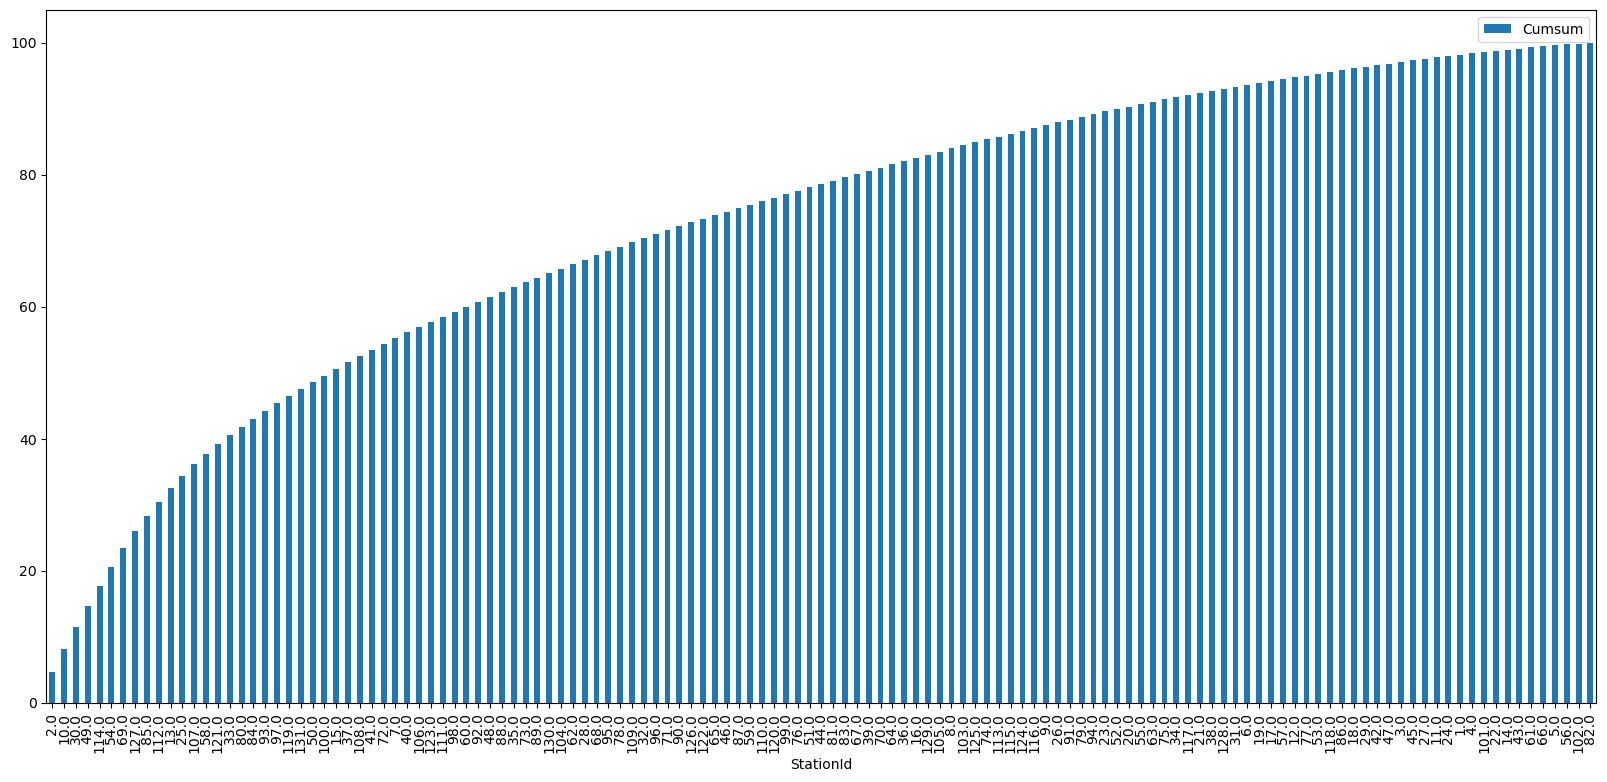

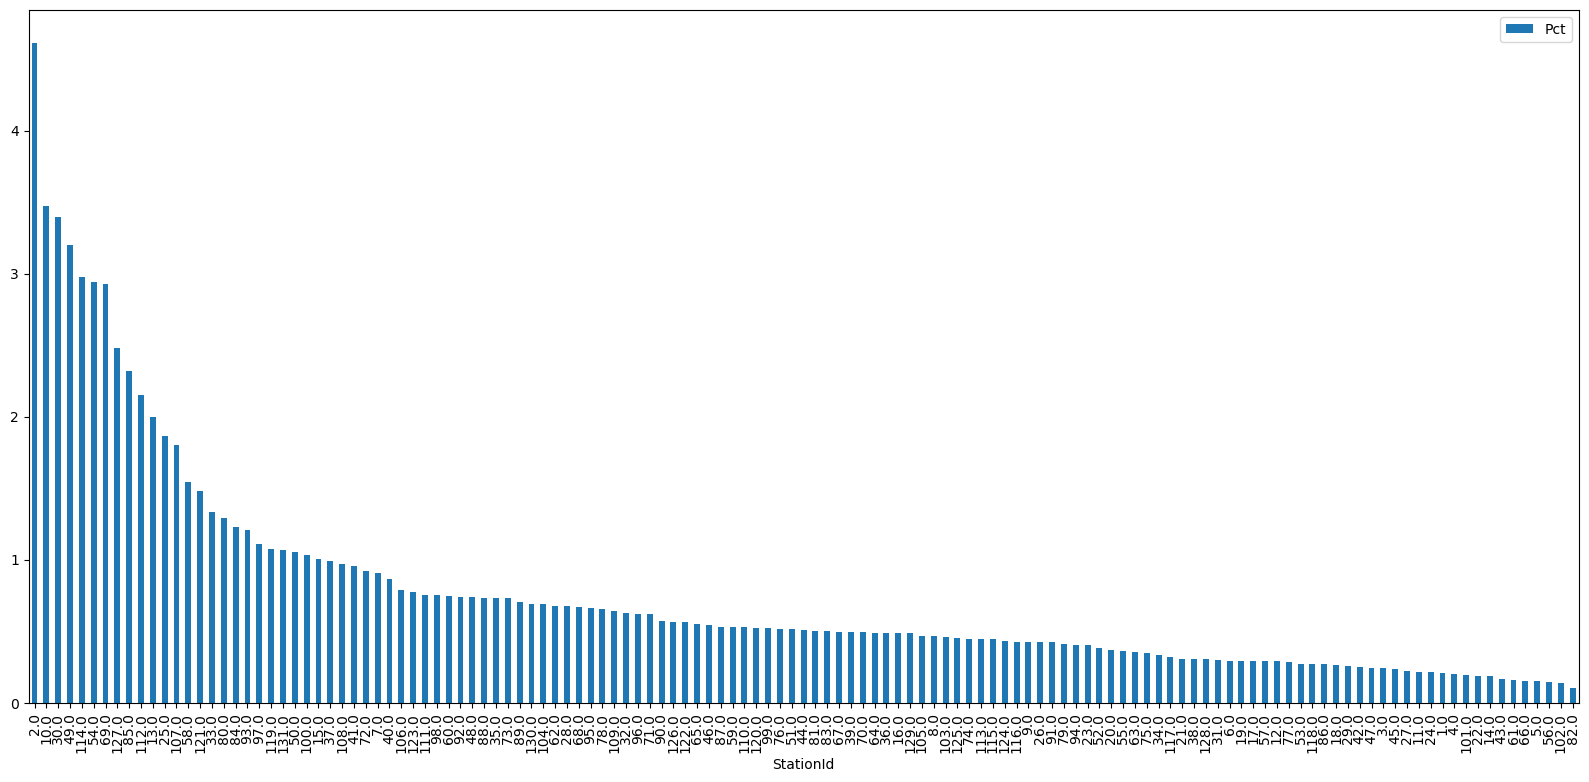

In [81]:
# title_2 = f"From {period_start_dt.strftime('%Y_%m_%d')} To {period_end_dt.strftime('%Y_%m_%d')}"

df_ax9 = (
    cumul_results[["TimeStamp", "StationId", "ELNX", "ELX"]]
    .groupby("StationId")
    .sum(numeric_only=True)
    .sort_values("StationId")
    # .head(20)
    .reset_index()
)

df_ax9[["ELNX", "ELX"]] = df_ax9[["ELNX", "ELX"]] / 1e3

df_ax9.rename({"ELNX": "Energie perdue SGRE", "ELX": "Energie perdue TAREC"}, inplace=True, axis=1)

df_ax9 = df_ax9.round(2)

df_ax9.set_index("StationId", inplace=True)

df_ax9 = df_ax9.sum(1).to_frame().sort_values(0, ascending=False)

df_ax9["Cumsum"] = 100 * (df_ax9[0] / df_ax9[0].sum()).cumsum()
df_ax9["Pct"] = 100 * (df_ax9[0] / df_ax9[0].sum())

df_ax9.plot(y="Cumsum", kind="bar", figsize=[20, 9])
df_ax9.plot(y="Pct", kind="bar", figsize=[20, 9])

In [91]:
df = (
    cumul_results[["TimeStamp", "StationId", "ELNX", "ELX"]]
    .groupby([cumul_results.TimeStamp.dt.to_period("M"),"StationId"])
    .sum(numeric_only=True).sum(1)
    .to_frame()
    .sort_values(["StationId", "TimeStamp"])
    .reset_index()
)
df
df.query("StationId.isin(@top_10)")

,TimeStamp,StationId,0
45,2023-01,10.0,131901.86
46,2023-02,10.0,127219.14
47,2023-03,10.0,4080.72
48,2023-04,10.0,34734.64
49,2023-05,10.0,0.00
60,2023-01,13.0,206307.92
61,2023-02,13.0,107133.03
62,2023-03,13.0,239.83
63,2023-04,13.0,8529.62
64,2023-05,13.0,0.00


In [92]:
top_10 = df_ax9.head(10).index

top_10

Float64Index([49.0, 54.0, 69.0, 127.0, 85.0, 13.0, 25.0, 10.0, 112.0, 107.0], dtype='float64', name='StationId')

In [22]:
results.query("StationId == 116").to_clipboard(decimal=",", sep=",", index=False)

In [29]:
results.query("`UK Text`.str.contains('low wind')").to_clipboard(decimal=",", sep=",", index=False)

In [54]:
results.query("EL_Misassigned > 0 & (prev_AcWindSp > 5 | next_AcWindSp > 5) & (`Period 0(s)` == 600)")

## Ajustements

### 2022 Déclenchement réseau du 11 au 17 09 2022 

In [34]:
# Tous (ELNX et EL_PowerRed) comptabiliser sur TAREC

ajust_start = "2022-09-11 00:00"
ajust_end = "2022-09-17 16:00"

ajust_start_dt = dt.strptime(ajust_start, "%Y-%m-%d %H:%M")
ajust_end_dt = dt.strptime(ajust_end, "%Y-%m-%d %H:%M")

period_range = pd.period_range(start=ajust_start_dt, end=ajust_end_dt, freq="M")
period_range

# results = results.query("@period_start <= TimeStamp <= @period_end")

ajust_mask = (results.TimeStamp >= ajust_start_dt) & (results.TimeStamp <= ajust_end_dt)

results.loc[ajust_mask, "ELX"] = (
    results.loc[ajust_mask, "ELX"] + results.loc[ajust_mask, "EL_PowerRed"]
)
results.loc[ajust_mask, "EL_PowerRed"] = 0

results.loc[ajust_mask, "ELX"] = results.loc[ajust_mask, "ELX"] + results.loc[ajust_mask, "ELNX"]
results.loc[ajust_mask, "ELNX"] = 0
# --------------------------------------------------------------------------------------------------

In [35]:
# Tous (ELNX et EL_PowerRed) comptabiliser sur TAREC

ajust_start = "2022-09-11 00:00"
ajust_end = "2022-09-17 16:00"

ajust_start_dt = dt.strptime(ajust_start, "%Y-%m-%d %H:%M")
ajust_end_dt = dt.strptime(ajust_end, "%Y-%m-%d %H:%M")

period_range = pd.period_range(start=ajust_start_dt, end=ajust_end_dt, freq="M")
period_range
# --------------------------------------------------------------------------------------------------

ajust_mask = (cumul_results.TimeStamp >= ajust_start_dt) & (
    cumul_results.TimeStamp <= ajust_end_dt
)

cumul_results.loc[ajust_mask, "ELX"] = (
    cumul_results.loc[ajust_mask, "ELX"] + cumul_results.loc[ajust_mask, "EL_PowerRed"]
)
cumul_results.loc[ajust_mask, "EL_PowerRed"] = 0

cumul_results.loc[ajust_mask, "ELX"] = (
    cumul_results.loc[ajust_mask, "ELX"] + cumul_results.loc[ajust_mask, "ELNX"]
)
cumul_results.loc[ajust_mask, "ELNX"] = 0

### 2022 Déclenchement réseau du 13/11/2022

In [36]:
# EL_PowerRed du 13 à comptabiliser sur TAREC

ajust_start = "2022-11-13 00:00"
ajust_end = "2022-11-14 00:00"

ajust_start_dt = dt.strptime(ajust_start, "%Y-%m-%d %H:%M")
ajust_end_dt = dt.strptime(ajust_end, "%Y-%m-%d %H:%M")

period_range = pd.period_range(start=ajust_start_dt, end=ajust_end_dt, freq="M")
period_range

# results = results.query("@period_start <= TimeStamp <= @period_end")

ajust_mask = (results.TimeStamp >= ajust_start_dt) & (results.TimeStamp <= ajust_end_dt)

results.loc[ajust_mask, "ELX"] = (
    results.loc[ajust_mask, "ELX"] + results.loc[ajust_mask, "EL_PowerRed"]
)
results.loc[ajust_mask, "EL_PowerRed"] = 0

# --------------------------------------------------------------------------------------------------

# ELNX de 6h à 15h comptabiliser sur TAREC

ajust_start = "2022-11-13 06:00"
ajust_end = "2022-11-13 15:00"

ajust_start_dt = dt.strptime(ajust_start, "%Y-%m-%d %H:%M")
ajust_end_dt = dt.strptime(ajust_end, "%Y-%m-%d %H:%M")

period_range = pd.period_range(start=ajust_start_dt, end=ajust_end_dt, freq="M")
period_range

# results = results.query("@period_start <= TimeStamp <= @period_end")

ajust_mask = (results.TimeStamp >= ajust_start_dt) & (results.TimeStamp <= ajust_end_dt)

results.loc[ajust_mask, "ELX"] = results.loc[ajust_mask, "ELX"] + results.loc[ajust_mask, "ELNX"]
results.loc[ajust_mask, "ELNX"] = 0
# --------------------------------------------------------------------------------------------------

In [37]:
# EL_PowerRed du 13 à comptabiliser sur TAREC

ajust_start = "2022-11-13 00:00"
ajust_end = "2022-11-14 00:00"

ajust_start_dt = dt.strptime(ajust_start, "%Y-%m-%d %H:%M")
ajust_end_dt = dt.strptime(ajust_end, "%Y-%m-%d %H:%M")

period_range = pd.period_range(start=ajust_start_dt, end=ajust_end_dt, freq="M")
period_range

# cumul_results = cumul_results.query("@period_start <= TimeStamp <= @period_end")

ajust_mask = (cumul_results.TimeStamp >= ajust_start_dt) & (
    cumul_results.TimeStamp <= ajust_end_dt
)

cumul_results.loc[ajust_mask, "ELX"] = (
    cumul_results.loc[ajust_mask, "ELX"] + cumul_results.loc[ajust_mask, "EL_PowerRed"]
)
cumul_results.loc[ajust_mask, "EL_PowerRed"] = 0

# --------------------------------------------------------------------------------------------------

# ELNX de 6h à 15h comptabiliser sur TAREC

ajust_start = "2022-11-13 06:00"
ajust_end = "2022-11-13 15:00"

ajust_start_dt = dt.strptime(ajust_start, "%Y-%m-%d %H:%M")
ajust_end_dt = dt.strptime(ajust_end, "%Y-%m-%d %H:%M")

period_range = pd.period_range(start=ajust_start_dt, end=ajust_end_dt, freq="M")
period_range

# cumul_results = cumul_results.query("@period_start <= TimeStamp <= @period_end")

ajust_mask = (cumul_results.TimeStamp >= ajust_start_dt) & (
    cumul_results.TimeStamp <= ajust_end_dt
)

cumul_results.loc[ajust_mask, "ELX"] = (
    cumul_results.loc[ajust_mask, "ELX"] + cumul_results.loc[ajust_mask, "ELNX"]
)
cumul_results.loc[ajust_mask, "ELNX"] = 0
# --------------------------------------------------------------------------------------------------

### Corrosion Alarmcode == 1024

In [33]:
# ELNX corrosion a comptabiliser sur TAREC

period_ajust = "2023-01"

period_start_ajust = pd.Timestamp(f"{period_ajust}-01 00:00:00.000")
period_end_ajust = pd.Timestamp(f"{period_ajust}-01 00:00:00.000")


(
    period_alarms_ajust,
    _,
    _,
    _,
    _,
) = process_period_alarms(alarms, period_start, period_end)

for index, row in period_alarms_ajust.query("Alarmcode == 1024").iterrows():
    ajust_start_dt = row["TimeOn"]
    ajust_end_dt = row["TimeOff"]

    ajust_mask = (
        (results.TimeStamp >= ajust_start_dt)
        & (results.TimeStamp <= ajust_end_dt)
        & (results.StationId == row["StationId"])
    )

    results.loc[ajust_mask, "ELX"] = (
        results.loc[ajust_mask, "ELX"] + results.loc[ajust_mask, "ELNX"]
    )
    results.loc[ajust_mask, "ELNX"] = 0
    # --------------------------------------------------------------------------
    ajust_mask_cumul = (
        (cumul_results.TimeStamp >= ajust_start_dt)
        & (cumul_results.TimeStamp <= ajust_end_dt)
        & (cumul_results.StationId == row["StationId"])
    )

    cumul_results.loc[ajust_mask_cumul, "ELX"] = (
        cumul_results.loc[ajust_mask_cumul, "ELX"] + cumul_results.loc[ajust_mask_cumul, "ELNX"]
    )
    cumul_results.loc[ajust_mask_cumul, "ELNX"] = 0

### save adjusted grouped

In [38]:
Results_grouped = results[
    [
        "StationId",
        "wtc_kWG1TotE_accum",
        "Epot",
        "EL",
        "EL 115",
        "ELX",
        "ELNX",
        "EL_115_left",
        "EL_indefini",
        "EL_wind",
        "EL_wind_start",
        "EL_alarm_start",
        "EL_indefini_left",
        "Period 1(s)",
        "Period 0(s)",
        "Duration 115(s)",
        "Duration 20-25(s)",
        "Duration lowind(s)",
        "EL_2006",
        "Duration lowind_start(s)",
        "Duration alarm_start(s)",
        "EL_Misassigned",
        "EL_PowerRed",
    ]
]


Results_grouped = round(Results_grouped.groupby("StationId").sum().reset_index(), 2)

Ep = Results_grouped["wtc_kWG1TotE_accum"]
EL = Results_grouped["EL"]
ELX = Results_grouped["ELX"]
ELNX = Results_grouped["ELNX"]
EL_2006 = Results_grouped["EL_2006"]
EL_PowerRed = Results_grouped["EL_PowerRed"]
EL_Misassigned = Results_grouped["EL_Misassigned"]

ELX_eq = ELX - EL_Misassigned
ELNX_eq = ELNX + EL_2006 + EL_PowerRed + EL_Misassigned
Epot_eq = Ep + ELX_eq + ELNX_eq

EL_wind = Results_grouped["EL_wind"]
EL_wind_start = Results_grouped["EL_wind_start"]
EL_alarm_start = Results_grouped["EL_alarm_start"]

Results_grouped["MAA_brut"] = 100 * (Ep + ELX) / (Ep + ELX + ELNX + EL_2006 + EL_PowerRed)

Results_grouped["MAA_brut_mis"] = round(
    100 * (Ep + ELX_eq) / (Epot_eq),
    2,
)

Results_grouped["MAA_indefni_adjusted"] = (
    100 * (Ep + ELX) / (Ep + EL - (EL_wind + EL_wind_start + EL_alarm_start))
)

Results_grouped.index = Results_grouped.index + 1

Results_grouped.to_csv(
    f"C:/Users/saada/Documents/Tarec/Siege vs WD vs BAX/rapports_mensuel/{period_ajust}/grouped_adjusted_{period_ajust}-Availability.csv",
    decimal=",",
    sep=";",
)
print("Done")

Done


## Indispo

### indispo period

In [41]:
EL_period = results["EL"].sum()
ELX_period = results["ELX"].sum()
ELNX_period = results["ELNX"].sum()
EL_2006_period = results["EL_2006"].sum()
Ep_period = results["wtc_kWG1TotE_accum"].sum()
EL_PowerRed_period = results["EL_PowerRed"].sum()
EL_Misassigned_period = results["EL_Misassigned"].sum()

Epot_period = results["Epot"].sum()

ajust = 0 # 878_232 corrosion janvier 2023

ELX_eq_period = ELX_period - EL_Misassigned_period + ajust
ELNX_eq_period = ELNX_period + EL_2006_period + EL_PowerRed_period + EL_Misassigned_period - ajust

Epot_eq_period = Ep_period + ELX_eq_period + ELNX_eq_period

EL_wind_period = results["EL_wind"].sum()
EL_wind_start_period = results["EL_wind_start"].sum()
EL_alarm_start_period = results["EL_alarm_start"].sum()

MAA_period_brut = round(
    100
    * (Ep_period + ELX_period)
    / (Ep_period + ELX_period + ELNX_period + EL_2006_period + EL_PowerRed_period),
    2,
)

MAA_period_brut_mis = round(
    100 * (Ep_period + ELX_eq_period) / (Epot_eq_period),
    2,
)

In [42]:
(
    round(Ep_period / 1e3, 2),
    round(ELX_eq_period / 1e3, 2),
    round(ELNX_eq_period / 1e3, 2),
    round(EL_PowerRed_period / 1e3, 2),
    round(Epot_eq_period / 1e3, 2), 
)

(68509.95, 930.27, 4090.18, 2.13, 73530.4)

In [43]:
(
    round(Ep_period / 1e3, 2),
    round(ELX_eq_period / 1e3, 2),
    round(ELNX_eq_period / 1e3, 2),
    round(EL_PowerRed_period / 1e3, 2),
    round(Epot_eq_period / 1e3, 2),
)

(68509.95, 930.27, 4090.18, 2.13, 73530.4)

In [44]:
MAA_period_brut, MAA_period_brut_mis

(94.52, 94.44)

In [45]:
(
    round(100 * (ELX_eq_period) / (Epot_eq_period), 2),
    round(100 * (ELNX_eq_period) / (Epot_eq_period), 2),
)

(1.27, 5.56)

### indispo cumul

In [46]:
Ep_cumul = cumul_results["wtc_kWG1TotE_accum"].sum()
EL_cumul = cumul_results["EL"].sum()
ELX_cumul = cumul_results["ELX"].sum()
ELNX_cumul = cumul_results["ELNX"].sum()
EL_2006_cumul = cumul_results["EL_2006"].sum()
EL_PowerRed_cumul = cumul_results["EL_PowerRed"].sum()
EL_Misassigned_cumul = cumul_results["EL_Misassigned"].sum()

ELX_eq_cumul = ELX_cumul - EL_Misassigned_cumul
ELNX_eq_cumul = ELNX_cumul + EL_2006_cumul + EL_PowerRed_cumul + EL_Misassigned_cumul
Epot_eq_cumul = Ep_cumul + ELX_eq_cumul + ELNX_eq_cumul

Epot_cumul = cumul_results["Epot"].sum()

EL_wind_cumul = cumul_results["EL_wind"].sum()
EL_wind_start_cumul = cumul_results["EL_wind_start"].sum()
EL_alarm_start_cumul = cumul_results["EL_alarm_start"].sum()

MAA_cumul_brut = round(
    100
    * (Ep_cumul + ELX_cumul + EL_PowerRed_cumul)
    / (Ep_cumul + ELX_cumul + ELNX_cumul + EL_2006_cumul + EL_PowerRed_cumul),
    2,
)

MAA_cumul_brut_mis = round(100 * (Ep_cumul + ELX_eq_cumul) / (Epot_eq_cumul), 2)

In [47]:
Epot_eq_cumul , Epot_cumul

(73530400.0, 74571590.0)

In [48]:
MAA_cumul_brut, MAA_cumul_brut_mis

(94.52, 94.44)

In [49]:
(
    round(Ep_cumul / 1e3, 2),
    round(ELX_eq_cumul / 1e3, 2),
    round(ELNX_eq_cumul / 1e3, 2),
    round(EL_PowerRed_cumul / 1e3, 2),
    round(Epot_eq_cumul / 1e3, 2),
)

(68509.95, 930.27, 4090.18, 2.13, 73530.4)

In [50]:
(
    round(100 * (ELX_eq_cumul) / (Epot_eq_cumul), 2),
    round(100 * (ELNX_eq_cumul) / (Epot_eq_cumul), 2),
)

(1.27, 5.56)

### indispo par mois

In [65]:
cumul_results_mois = (
    cumul_results[
        [
            "TimeStamp",
            "wtc_kWG1TotE_accum",
            "EL",
            "ELX",
            "ELNX",
            "EL_2006",
            "EL_PowerRed",
            "EL_Misassigned",
        ]
    ]
    .groupby(cumul_results.TimeStamp.dt.to_period("M"))
    .sum()
)

Ep_cumul_grp = cumul_results_mois["wtc_kWG1TotE_accum"]
EL_cumul_grp = cumul_results_mois["EL"]
ELX_cumul_grp = cumul_results_mois["ELX"]
ELNX_cumul_grp = cumul_results_mois["ELNX"]
EL_2006_cumul_grp = cumul_results_mois["EL_2006"]
EL_PowerRed_cumul_grp = cumul_results_mois["EL_PowerRed"]
EL_Misassigned_cumul_grp = cumul_results_mois["EL_Misassigned"]

C:\Users\saada\AppData\Local\Temp\ipykernel_12480\2323953901.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()


In [114]:
ELNX_glob_cumul_grp = (
    ELNX_cumul_grp
    + EL_2006_cumul_grp
    + EL_PowerRed_cumul_grp
    + EL_Misassigned_cumul_grp
)
Epot_cumul_grp = (
    Ep_cumul_grp
    + ELX_cumul_grp
    + ELNX_glob_cumul_grp
    + EL_2006_cumul_grp
    + EL_PowerRed_cumul_grp
)

cumul_results_mois["Indispo. TAREC énergie (%)"] = round(
    100 * (ELX_cumul_grp - EL_Misassigned_cumul_grp) / (Epot_cumul_grp), 2
)
cumul_results_mois["Indispo. SGRE énergie (%)"] = round(
    100 * (ELNX_glob_cumul_grp) / (Epot_cumul_grp), 2
)

cumul_results_mois["Indispo. TAREC énergie (MWh)"] = round(
    (ELX_cumul_grp - EL_Misassigned_cumul_grp) / 1e3, 2
)
cumul_results_mois["Indispo. SGRE énergie (MWh)"] = round((ELNX_glob_cumul_grp) / 1e3, 2)

cumul_results_mois[["wtc_kWG1TotE_accum", "Indispo. TAREC énergie (%)", "Indispo. SGRE énergie (%)", "Indispo. TAREC énergie (MWh)", "Indispo. SGRE énergie (MWh)"]]


,wtc_kWG1TotE_accum,Indispo. TAREC énergie (%),Indispo. SGRE énergie (%),Indispo. TAREC énergie (MWh),Indispo. SGRE énergie (MWh)
TimeStamp,,,,,
2023-01,101739683.0,0.23,3.23,247.70,3402.33
2023-02,53122850.0,0.42,5.01,237.85,2817.54
2023-03,103738691.0,0.28,2.89,300.41,3093.27
2023-04,24929.0,0.00,1.52,0.00,0.39


In [106]:
df.to_clipboard(True, decimal=",")

In [38]:
cumul_results_mois["Indispo. TAREC énergie (%)"] = round(
    100 * ELX_cumul_grp / (Ep_cumul_grp + ELX_cumul_grp + ELNX_cumul_grp), 2
)
cumul_results_mois["Indispo. SGRE énergie (%)"] = round(
    100 * (ELNX_cumul_grp) / (Ep_cumul_grp + ELX_cumul_grp + ELNX_cumul_grp), 2
)

cumul_results_mois["Indispo. TAREC énergie (MWh)"] = round(ELX_cumul_grp / 1e3, 2)
cumul_results_mois["Indispo. SGRE énergie (MWh)"] = round((ELNX_cumul_grp) / 1e3, 2)

cumul_results_mois.reset_index().to_clipboard(index=False)

## MTTI MTTR MTBF cumulé

In [51]:
freq_cumul = len(cumul_main_result_sum.query(mt_query, engine="python"))

duree_cumul = (
    cumul_main_result_sum.query(mt_query, engine="python").RealPeriod.sum().total_seconds() / 3600
)

mtbf_cumul = (days_in_cumul * 24 * 131 - duree_cumul) / freq_cumul / 24

mttr_cumul = duree_cumul / freq_cumul

mtbf_cumul, mttr_cumul

(35.27907723420966, 23.516432093253968)

In [52]:
# cumul_main_result_sum.query(
#     query + '& `Error Group` == "Hydraulics"').groupby('Alarmcode')

# cumul_main_result_sum.query(
#     query + '& `Error Group` == "Yaw"').groupby('Alarmcode').count()


In [53]:
mtti_cumul_df = (
    cumul_main_result_sum.groupby("StationId")
    .apply(lambda x: mtti(x, x.name, cumul_alarms, alarm_50000))
    .reset_index(drop=True)
)
mtti_cumul_df = mtti_cumul_df.query(f'InterTimeOn >= "{cumul_start}"')

mtti_cumul = (
    mtti_cumul_df["TimeTI"].sum()
    / len(mtti_cumul_df.query("TimeTI > @pd.Timedelta(0)", engine="python"))
).total_seconds() / 3600

mtti_cumul


6.3656988475

In [54]:
mtti_cumul = mtti_cumul_df["TimeTI"].mean().total_seconds() / 3600
mtti_cumul


6.3656988475

### MTTR MTBF Ebop

In [71]:
freq_cumul_ebop = len(cumul_main_result_sum.query("Alarmcode == 1007", engine="python"))

duree_cumul_ebop = (
    cumul_main_result_sum.query("Alarmcode == 1007", engine="python").RealPeriod.sum().days
)

mtbf_cumul_ebop = (days_in_cumul * 131 - duree_cumul_ebop) / freq_cumul_ebop

mttr_cumul_ebop = duree_cumul_ebop * 24 / freq_cumul_ebop

mtbf_cumul_ebop, mttr_cumul_ebop

(47.262425447316105, 6.417495029821073)

In [84]:
for month in range(1, 3 + 1):  # range(1, period_month+1):

    period_cumul = f"{str(period_year).zfill(2)}-{str(month).zfill(2)}"
    period_start = pd.Timestamp(f"{period_cumul}-01 00:00:00.000")
    period_end = pd.Timestamp(f"{period_cumul}-01 00:00:00.000") + relativedelta(months=1)

    (
        period_alarms,
        result_sum,
        alarms_result_sum,
        parent_result_sum,
        main_result_sum,
    ) = process_period_alarms(alarms, period_start, period_end)

    freq_ebop = len(main_result_sum.query("Alarmcode == 1007", engine="python"))

    duree_ebop = main_result_sum.query("Alarmcode == 1007", engine="python").RealPeriod.sum().days

    mtbf_ebop = (days_in_cumul * 131 - duree_ebop) / freq_ebop

    mttr_ebop = duree_ebop * 24 / freq_ebop

    print(period_cumul, round(mtbf_ebop, 2), round(mttr_ebop, 2))

TimeOff NAs = 0
2022-01 2078.78 3.13
TimeOff NAs = 0
2022-02 568.98 6.0
TimeOff NAs = 0
2022-03 47815.0 0.0


In [114]:
l = [
    # 1002,
    # 1004,
    # 1005,
    1007,
    # 1009,
    # 1013,
    # 1018,
    # 1019,
    # 1021,
    # 1027,
    # 1028
]
df = alarms.query("Alarmcode.isin(@l)", engine="python")
df.groupby(df.TimeOn.dt.month).count()

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID
TimeOn,,,,,,
1,23,23,23,23,23,23
2,85,85,85,85,85,85
3,1,1,1,1,1,1
4,1,1,1,1,1,1
5,173,173,173,173,173,173
6,134,134,134,134,134,134
7,91,91,91,91,91,91
8,7,7,7,7,7,7
9,245,245,245,245,245,245


## Table 1 ax1

### row 0

In [55]:
df_ax1.at[i_period, "Indispo. Energie Tarec %"] = round(
    100 * (ELX_eq_period) / (Epot_eq_period), 2
)
df_ax1.at[i_period, "Indispo. Energie Siemens %"] = round(
    100 * (ELNX_eq_period) / (Epot_eq_period), 2
)
df_ax1.at[i_period, "Indispo. Energie Total %"] = round(
    100 * (ELX_eq_period + ELNX_eq_period) / (Epot_eq_period), 2
)


### row 1

In [56]:
nbr_jrs_total = len(pd.date_range(f"{period_year}-01-01", f"{lastday_period}", freq="D"))

i_cumul = "Indicateurs annuels :"

df_ax1.at[i_cumul, "Indispo. Temps Tarec %"] = round(
    100 * cumul_results["Period 0(s)"].sum() / 3600 / 24 / 131 / nbr_jrs_total, 2
)
df_ax1.at[i_cumul, "Indispo. Temps Siemens %"] = round(
    100 * cumul_results["Period 1(s)"].sum() / 3600 / 24 / 131 / nbr_jrs_total, 2
)
df_ax1.at[i_cumul, "Indispo. Temps Total %"] = round(
    100 * cumul_results["RealPeriod"].sum() / 3600 / 24 / 131 / nbr_jrs_total, 2
)

# ---------------------------------------------------------------------------------------
df_ax1.at[i_cumul, "Indispo. Energie Tarec %"] = round(100 * (ELX_eq_cumul) / (Epot_eq_cumul), 2)
df_ax1.at[i_cumul, "Indispo. Energie Siemens %"] = round(
    100 * (ELNX_eq_cumul) / (Epot_eq_cumul), 2
)
df_ax1.at[i_cumul, "Indispo. Energie Total %"] = round(
    100 * (ELX_eq_cumul + ELNX_eq_cumul) / (Epot_eq_cumul), 2
)


df_ax1.at[i_cumul, "Power Boost en MWh"] = round(boost_cumul, 2)

# df_ax1.at[i_cumul, 8] = ratio_cumul
#
df_ax1.at[i_cumul, "MTBF - Mean Time Between Failure"] = round(mtbf_cumul, 2)
df_ax1.at[i_cumul, "MTTR - Mean Time To Repair"] = round(mttr_cumul, 2)
df_ax1.at[i_cumul, "MTTI - Mean Time To Intervention"] = round(mtti_cumul, 2)
# ---------------------------------------------------------------------------------------
df_ax1.at[i_cumul, "Pertes élctriques en MWh"] = round(
    cumul_results.wtc_kWG1TotE_accum.sum() / 1000 - onee_cumul, 2
)
df_ax1.at[i_cumul, "Compteurs ONEE MWh"] = round(onee_cumul, 2)


In [57]:
df_ax1

,LTA-Lost Time,Indispo. Energie Total %,Indispo. Energie Tarec %,Indispo. Energie Siemens %,Indispo. Temps Total %,Indispo. Temps Tarec %,Indispo. Temps Siemens %,Indispo. Temps ONEE %,Indispo. Temps Ebop %,Pertes élctriques en MWh,Power Boost en MWh,Performance moyenne des turbines,MTBF - Mean Time Between Failure,MTTR - Mean Time To Repair,MTTI - Mean Time To Intervention,Compteurs ONEE MWh
Indicateurs annuels :,0.0,6.83,1.27,5.56,6.45,2.12,4.32,0.0,0.0,888.21,488.74,0.0,35.28,23.52,6.37,67621.74
Indicateurs du mois 2024-01 :,0.0,6.83,1.27,5.56,6.45,2.12,4.32,0.0,0.0,888.21,488.74,0.0,35.28,23.52,6.37,67621.74


### Engie df

In [35]:
round(
    cumul_results[
        [
            "met_WindSpeedRot_mean_38",
            "met_WindSpeedRot_mean_39",
            "met_WindSpeedRot_mean_246",
        ]
    ]
    .groupby(cumul_results.TimeStamp.dt.to_period("M"))
    .mean()
    .mean(1),
    2,
).to_frame()

,0
TimeStamp,
2023-01,8.80
2023-02,6.57
2023-03,8.56
2023-04,8.09
2023-05,8.44
2023-06,7.04
2023-07,10.64
2023-08,9.23
2023-09,7.15


In [36]:
nbr_jrs_total = len(
    pd.date_range(f"{period_year}-01-01", f"{lastday_period}", freq="D")
)

hakim_df = pd.DataFrame(index=[period])

hakim_df["Indispo. TAREC temps (%)"] = df_ax1.at[i_period, "Indispo. Temps Tarec %"]

hakim_df["Indispo. SGRE temps (%)"] = df_ax1.at[i_period, "Indispo. Temps Siemens %"]

hakim_df["Indispo. TAREC énergie (%)"] = df_ax1.at[i_period, "Indispo. Energie Tarec %"]

hakim_df["Indispo. SGRE énergie (%)"] = df_ax1.at[
    i_period, "Indispo. Energie Siemens %"
]

hakim_df["Indispo. TAREC énergie (MWh)"] = round(ELX_eq_period / 1e3, 2)
hakim_df["Indispo. SGRE énergie (MWh)"] = round(ELNX_eq_period / 1e3, 2)

# hakim_df['Indispo. TAREC énergie (MWh)'] = round(ELX_period / 1e3, 2)
# hakim_df['Indispo. SGRE énergie (MWh)'] = round(
#     (ELNX_period + EL_2006_period + EL_PowerRed_period) / 1e3, 2)

hakim_df["Pertes électriques (MWh)"] = df_ax1.at[i_period, "Pertes élctriques en MWh"]
hakim_df["Vent moyen Mâts (m/s)"] = round(
    results[
        [
            "met_WindSpeedRot_mean_38",
            "met_WindSpeedRot_mean_39",
            "met_WindSpeedRot_mean_246",
        ]
    ]
    .mean()
    .mean(),
    2,
)

hakim_df.columns.name = "."

hakim_df


.,Indispo. TAREC temps (%),Indispo. SGRE temps (%),Indispo. TAREC énergie (%),Indispo. SGRE énergie (%),Indispo. TAREC énergie (MWh),Indispo. SGRE énergie (MWh),Pertes électriques (MWh),Vent moyen Mâts (m/s)
2023-12,1.16,3.61,0.21,5.36,130.08,3399.79,1159.89,6.89


### Rapport mensuel Exploitation 

In [58]:
from math import radians, degrees
from cmath import rect, phase
def mean_angle(deg):
    mean = degrees(phase(sum(rect(1, radians(d)) for d in deg) / len(deg)))
    if mean > 0:
        return mean
    else:
        return mean + 360

In [59]:
nbr_jrs_total = len(pd.date_range(f"{period_year}-01-01", f"{lastday_period}", freq="D"))

period_temp = period.replace("-", "_")

exploi_df = pd.DataFrame(index=["Cumul", period_temp])

exploi_df.loc[period_temp, "Indispo. TAREC temps (%)"] = df_ax1.at[i_period, "Indispo. Temps Tarec %"]
exploi_df.loc["Cumul", "Indispo. TAREC temps (%)"] = df_ax1.at["Indicateurs annuels :", "Indispo. Temps Tarec %"]

exploi_df.loc[period_temp, "Indispo. SGRE temps (%)"] = df_ax1.at[i_period, "Indispo. Temps Siemens %"]
exploi_df.loc["Cumul", "Indispo. SGRE temps (%)"] = df_ax1.at["Indicateurs annuels :", "Indispo. Temps Siemens %"]

exploi_df.loc[period_temp, "Indispo. TAREC énergie (%)"] = df_ax1.at[i_period, "Indispo. Energie Tarec %"]
exploi_df.loc["Cumul", "Indispo. TAREC énergie (%)"] = df_ax1.at["Indicateurs annuels :", "Indispo. Energie Tarec %"]

exploi_df.loc[period_temp, "Indispo. SGRE énergie (%)"] = df_ax1.at[i_period, "Indispo. Energie Siemens %"]
exploi_df.loc["Cumul", "Indispo. SGRE énergie (%)"] = df_ax1.at["Indicateurs annuels :", "Indispo. Energie Siemens %"]

exploi_df.loc[period_temp, "Indispo. TAREC énergie (MWh)"] = round(ELX_eq_period / 1e3, 2)
exploi_df.loc["Cumul", "Indispo. TAREC énergie (MWh)"] = round(ELX_eq_cumul / 1e3, 2)

exploi_df.loc[period_temp, "Indispo. SGRE énergie (MWh)"] = round(ELNX_eq_period / 1e3, 2)
exploi_df.loc["Cumul", "Indispo. SGRE énergie (MWh)"] = round(ELNX_eq_cumul / 1e3, 2)

exploi_df.loc[period_temp, "PEP (MWh)"] = round(Epot_eq_period / 1e3, 2)
exploi_df.loc["Cumul", "PEP (MWh)"] = round(Epot_eq_cumul / 1e3, 2)

# exploi_df.loc[period_temp, "Pertes électriques (MWh)"] = df_ax1.at[i_period, "Pertes élctriques en MWh"]
# exploi_df.loc["Cumul", "Pertes électriques (MWh)"] = df_ax1.at["Indicateurs annuels :", "Pertes élctriques en MWh"]

exploi_df.loc[period_temp, "Boost (MWh)"] = boost_period
exploi_df.loc["Cumul", "Boost (MWh)"] = boost_cumul

exploi_df.loc[period_temp, "Pertes élctriques (MWh)"] = round(results.wtc_kWG1TotE_accum.sum() / 1e3 - onee_period, 2)
exploi_df.loc["Cumul", "Pertes élctriques (MWh)"] = round(cumul_results.wtc_kWG1TotE_accum.sum() / 1000 - onee_cumul, 2)

exploi_df.loc[period_temp, "Vent moyen Mâts (m/s)"] = round(
    results[
        [
            "met_WindSpeedRot_mean_38",
            "met_WindSpeedRot_mean_39",
            "met_WindSpeedRot_mean_246",
        ]
    ]
    .mean()
    .mean(),
    2,
)


exploi_df.loc[period_temp, "Direction moyenne Mâts (°)"] = mean_angle(
    (
        results[
            [
                "met_WinddirectionRot_mean_38",
                "met_WinddirectionRot_mean_39",
                "met_WinddirectionRot_mean_246",
            ]
        ].apply(mean_angle)
    )
)

exploi_df.loc["Cumul", "Vent moyen Mâts (m/s)"] = round(
    cumul_results[
        [
            "met_WindSpeedRot_mean_38",
            "met_WindSpeedRot_mean_39",
            "met_WindSpeedRot_mean_246",
        ]
    ]
    .mean()
    .mean(),
    2,
)


exploi_df.loc["Cumul", "Direction moyenne Mâts (°)"] = mean_angle(
    (
        cumul_results[
            [
                "met_WinddirectionRot_mean_38",
                "met_WinddirectionRot_mean_39",
                "met_WinddirectionRot_mean_246",
            ]
        ].apply(mean_angle)
    )
)

exploi_df.columns.name = "."

exploi_df.applymap(lambda x: "{:,.2f}".format(x))

.,Indispo. TAREC temps (%),Indispo. SGRE temps (%),Indispo. TAREC énergie (%),Indispo. SGRE énergie (%),Indispo. TAREC énergie (MWh),Indispo. SGRE énergie (MWh),PEP (MWh),Boost (MWh),Vent moyen Mâts (m/s),Direction moyenne Mâts (°)
Cumul,2.12,4.32,1.27,5.56,930.27,"4,090.18","73,530.40",488.74,7.04,78.74
2024_01,2.12,4.32,1.27,5.56,930.27,"4,090.18","73,530.40",488.74,7.04,78.74


## str ax12

In [101]:
# str_ax12 = f"""ELNX imputée à SGRE:  {ELNX_cumul} GWh ({ELNX_period} GWh pour {period_month_name} {period_year})
# Disponibilité en énergie selon FSA : {MAA_cumul_brut}% ({MAA_period_brut} % pour {period_month_name} {period_year})
# Disponibilité en énergie constatée : {MAA_cumul}% ({MAA_period} % pour {period_month_name} {period_year})"""

In [94]:
str_ax12 = f"""Energie imputée à SGRE: {period_year} YTD {ELNX_eq_cumul/1e6 :.2f} GWh & Mensuel {ELNX_eq_period/1e6 :.2f} GWh
Disponibilité en énergie selon FSA: {period_year} YTD {MAA_cumul_brut_mis} % & Mensuel {MAA_period_brut_mis} %"""


In [95]:
str_ax12

'Energie imputée à SGRE: 2023 YTD 35.16 GWh & Mensuel 3.40 GWh\nDisponibilité en énergie selon FSA: 2023 YTD 96.97 % & Mensuel 94.64 %'

# Export XLSX writer

## Textboxs (chart titles ...)

In [ ]:
period_month_name_ascii

In [102]:
textboxes = pd.Series(
{
    "reference": f"FR.PPO.01.{period}",
    "title": f"Tableau de bord de Performance — {period_month_name} {period_year}",
    "indicateurs": f"""Indicateurs
{period_month_name} {period_year}:""",
    "ax5": f"Durée et fréquence par catégorie d’alarme: {period}",
    "ax6": f"Durée et fréquence par code d’alarme: {period}",
    "ax9": f"Durée et fréquence des arrêts par turbine: {period}",
    "ax10": f"Énergie perdue en MWh selon FSA: {period}",
    "ax19": f"Ratio Courbe Théorique vs Courbe Réelle du {period}",
    "ratio_min": f"Le LIDAR devra être placé devant la turbine n°{int(df_ax19.iloc[df_ax19.Ratio.idxmin()].StationId)}",
}
)
textboxes

reference                                      FR.PPO.01.2022-12
title             Tableau de bord de Performance — Décembre 2022
indicateurs                          Indicateurs\nDécembre 2022:
ax5            Durée et fréquence par catégorie d’alarme: 202...
ax6                Durée et fréquence par code d’alarme: 2022-12
ax9            Durée et fréquence des arrêts par turbine: 202...
ax10                    Énergie perdue en MWh selon FSA: 2022-12
ax19           Ratio Courbe Théorique vs Courbe Réelle du 202...
ratio_min      Le LIDAR devra être placé devant la turbine n°111
dtype: object

In [123]:
writer = pd.ExcelWriter(f"./input/{period}/output_xlsxwriter.xlsx", engine="xlsxwriter")
# -------------------------------------------------------------------------------------------

workbook = writer.book
dashsheet = workbook.add_worksheet("Dash")

# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax1-------------------------------------------------
# -------------------------------------------------------------------------------------------

textboxes.to_excel(writer, sheet_name="textboxes", header=None)

# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax1-------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax1.to_excel(writer, sheet_name="ax1")

# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax3-------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax3.to_excel(writer, index=False, sheet_name="ax3")

worksheet = writer.sheets["ax3"]


def make_chart_ax3():
    column_chart = workbook.add_chart({"type": "column"})

    column_chart.add_series(
        {
            "name": ["ax3", 0, 2],
            "categories": ["ax3", 1, 0, 13, 0],
            "values": ["ax3", 1, 2, 13, 2],
        }
    )
    line_chart = workbook.add_chart({"type": "line"})
    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series(
        {
            "values": ["ax3", 1, 1, 13, 1],
            "categories": ["ax3", 1, 0, 13, 0],
            "name": ["ax3", 0, 1],
            "y2_axis": True,
        }
    )
    # Combine the charts.
    column_chart.combine(line_chart)
    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax3.columns[0]})
    column_chart.set_y_axis({"name": "Durée en h"})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {
            "name": "Cumul annuel par type d'alarme",
            "name_font": {"size": 12, "bold": True},
        }
    )
    line_chart.set_y2_axis({"name": df_ax3.columns[1]})
    return column_chart


column_chart = make_chart_ax3()
# Insert the chart into the worksheet.
worksheet.insert_chart("E2", column_chart)

column_chart = make_chart_ax3()
# Insert the chart into the worksheet.
dashsheet.insert_chart("B2", column_chart)

# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax4-------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax4.to_excel(writer, index=False, sheet_name="ax4")
worksheet = writer.sheets["ax4"]


def make_chart_ax4():
    column_chart = workbook.add_chart({"type": "column"})

    column_chart.add_series(
        {
            "name": ["ax4", 0, 2],
            "categories": ["ax4", 1, 0, 13, 0],
            "values": ["ax4", 1, 2, 13, 2],
        }
    )
    line_chart = workbook.add_chart({"type": "line"})
    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series(
        {
            "values": ["ax4", 1, 1, 13, 1],
            "categories": ["ax4", 1, 0, 13, 0],
            "name": ["ax4", 0, 1],
            "y2_axis": True,
        }
    )
    # Combine the charts.
    column_chart.combine(line_chart)
    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax4.columns[0]})
    column_chart.set_y_axis({"name": "MTBF en j"})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {
            "name": f"MTBF et MTTR par catégorie sur l'année {period_year}",
            "name_font": {"size": 12, "bold": True},
        }
    )
    line_chart.set_y2_axis({"name": "MTTR en h"})
    return column_chart


column_chart = make_chart_ax4()
# Insert the chart into the worksheet.
worksheet.insert_chart("E2", column_chart)

column_chart = make_chart_ax4()
# Insert the chart into the worksheet.
dashsheet.insert_chart("J2", column_chart)

# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax5-------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax5.to_excel(writer, index=False, sheet_name="ax5")

worksheet = writer.sheets["ax5"]


def make_chart_ax5():
    column_chart = workbook.add_chart({"type": "column"})

    column_chart.add_series(
        {
            "name": ["ax5", 0, 2],
            "categories": ["ax5", 1, 0, 13, 0],
            "values": ["ax5", 1, 2, 13, 2],
        }
    )
    line_chart = workbook.add_chart({"type": "line"})
    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series(
        {
            "values": ["ax5", 1, 1, 13, 1],
            "categories": ["ax5", 1, 0, 13, 0],
            "name": ["ax5", 0, 1],
            "y2_axis": True,
        }
    )
    # Combine the charts.
    column_chart.combine(line_chart)
    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax5.columns[0]})
    column_chart.set_y_axis({"name": "Durée en h"})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {"name": f"Type d'alarme {period}", "name_font": {"size": 12, "bold": True}}
    )

    line_chart.set_y2_axis({"name": df_ax5.columns[1]})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax5()
# Insert the chart into the worksheet.
worksheet.insert_chart("E2", column_chart)

column_chart = make_chart_ax5()
# Insert the chart into the worksheet.
dashsheet.insert_chart("R2", column_chart)


# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax5bis-------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax5_cumul.to_excel(writer, index=False, sheet_name="ax5bis")

worksheet = writer.sheets["ax5bis"]


def make_chart_ax5bis():
    column_chart = workbook.add_chart({"type": "column"})

    column_chart.add_series(
        {
            "name": ["ax5bis", 0, 2],
            "categories": ["ax5bis", 1, 0, 13, 0],
            "values": ["ax5bis", 1, 2, 13, 2],
        }
    )
    line_chart = workbook.add_chart({"type": "line"})
    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series(
        {
            "values": ["ax5bis", 1, 1, 13, 1],
            "categories": ["ax5bis", 1, 0, 13, 0],
            "name": ["ax5bis", 0, 1],
            "y2_axis": True,
        }
    )
    # Combine the charts.
    column_chart.combine(line_chart)
    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax5_cumul.columns[0]})
    column_chart.set_y_axis({"name": "Durée en h"})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {"name": f"Type d'alarme : Cumul annuel", "name_font": {"size": 12, "bold": True}}
    )

    line_chart.set_y2_axis({"name": df_ax5_cumul.columns[1]})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax5bis()
# Insert the chart into the worksheet.
worksheet.insert_chart("E2", column_chart)

column_chart = make_chart_ax5bis()
# Insert the chart into the worksheet.
dashsheet.insert_chart("R2", column_chart)

# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax6-------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax6.to_excel(writer, index=False, sheet_name="ax6")

worksheet = writer.sheets["ax6"]


def make_chart_ax6():
    column_chart = workbook.add_chart({"type": "column"})

    column_chart.add_series(
        {
            "name": ["ax6", 0, 2],
            "categories": ["ax6", 1, 0, 20, 0],
            "values": ["ax6", 1, 2, 20, 2],
        }
    )

    column_chart.add_series(
        {
            "name": ["ax6", 0, 3],
            "categories": ["ax6", 1, 0, 20, 0],
            "values": ["ax6", 1, 3, 20, 3],
        }
    )
    line_chart = workbook.add_chart({"type": "line"})
    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series(
        {
            "values": ["ax6", 1, 1, 20, 1],
            "categories": ["ax6", 1, 0, 20, 0],
            "name": ["ax6", 0, 1],
            "y2_axis": True,
        }
    )
    # Combine the charts.
    column_chart.combine(line_chart)
    # Configure the chart axes.
    column_chart.set_x_axis({"name": df_ax6.columns[0]})
    column_chart.set_y_axis({"name": "Durée en h"})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title({"name": f"Alarmes {period}", "name_font": {"size": 12, "bold": True}})
    line_chart.set_y2_axis({"name": df_ax6.columns[1]})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax6()
# Insert the chart into the worksheet.
worksheet.insert_chart("E2", column_chart)

column_chart = make_chart_ax6()
# Insert the chart into the worksheet.
dashsheet.insert_chart("Z2", column_chart)


# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax6bis-------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax6_cumul.to_excel(writer, index=False, sheet_name="ax6bis")

worksheet = writer.sheets["ax6bis"]


def make_chart_ax6bis():
    column_chart = workbook.add_chart({"type": "column"})

    column_chart.add_series(
        {
            "name": ["ax6bis", 0, 2],
            "categories": ["ax6bis", 1, 0, 20, 0],
            "values": ["ax6bis", 1, 2, 20, 2],
        }
    )

    column_chart.add_series(
        {
            "name": ["ax6bis", 0, 3],
            "categories": ["ax6bis", 1, 0, 20, 0],
            "values": ["ax6bis", 1, 3, 20, 3],
        }
    )
    line_chart = workbook.add_chart({"type": "line"})
    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series(
        {
            "values": ["ax6bis", 1, 1, 20, 1],
            "categories": ["ax6bis", 1, 0, 20, 0],
            "name": ["ax6bis", 0, 1],
            "y2_axis": True,
        }
    )
    # Combine the charts.
    column_chart.combine(line_chart)
    # Configure the chart axes.
    column_chart.set_x_axis({"name": df_ax6_cumul.columns[0]})
    column_chart.set_y_axis({"name": "Durée en h"})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {"name": f"Alarmes : Cumul annuel", "name_font": {"size": 12, "bold": True}}
    )
    line_chart.set_y2_axis({"name": df_ax6_cumul.columns[1]})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax6bis()
# Insert the chart into the worksheet.
worksheet.insert_chart("E2", column_chart)

column_chart = make_chart_ax6bis()
# Insert the chart into the worksheet.
dashsheet.insert_chart("Z2", column_chart)
# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax7-------------------------------------------------
# -------------------------------------------------------------------------------------------

worksheet = workbook.add_worksheet("ax7")

options = {
    "x_scale": 3,
    "y_scale": 25,
}
worksheet.insert_textbox(0, 0, ax7, options)
# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax7bis-------------------------------------------------
# -------------------------------------------------------------------------------------------

worksheet = workbook.add_worksheet("ax7bis")

options = {
    "x_scale": 3,
    "y_scale": 25,
}
worksheet.insert_textbox(0, 0, ax7_cumul, options)

# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax8-------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax8.to_excel(writer, index=False, sheet_name="ax8")

worksheet = writer.sheets["ax8"]


def make_chart_ax8():
    column_chart = workbook.add_chart({"type": "column", "subtype": "stacked"})

    column_chart.add_series(
        {
            "name": ["ax8", 0, 1],
            "categories": ["ax8", 1, 0, 20, 0],
            "values": ["ax8", 1, 1, 20, 1],
        }
    )
    column_chart.add_series(
        {
            "name": ["ax8", 0, 2],
            "categories": ["ax8", 1, 0, 20, 0],
            "values": ["ax8", 1, 2, 20, 2],
        }
    )
    line_chart = workbook.add_chart({"type": "line"})
    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series(
        {
            "values": ["ax8", 1, 3, 20, 3],
            "categories": ["ax8", 1, 0, 20, 0],
            "name": ["ax8", 0, 3],
            "y2_axis": True,
        }
    )
    line_chart.add_series(
        {
            "values": ["ax8", 1, 4, 20, 4],
            "categories": ["ax8", 1, 0, 20, 0],
            "name": ["ax8", 0, 4],
            "y2_axis": True,
        }
    )
    # Combine the charts.
    column_chart.combine(line_chart)
    # Configure the chart axes.
    column_chart.set_x_axis({"name": df_ax8.columns[0]})
    column_chart.set_y_axis({"name": "Durée en h"})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {
            "name": "Arrêts turbines : Cumul Annuel",
            "name_font": {"size": 12, "bold": True},
        }
    )
    line_chart.set_y2_axis({"name": "Freq"})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax8()
# Insert the chart into the worksheet.
worksheet.insert_chart("G2", column_chart)

column_chart = make_chart_ax8()
# Insert the chart into the worksheet.
dashsheet.insert_chart("B17", column_chart)


# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax9-------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax9.to_excel(writer, index=False, sheet_name="ax9")

worksheet = writer.sheets["ax9"]


def make_chart_ax9():
    column_chart = workbook.add_chart({"type": "column", "subtype": "stacked"})

    column_chart.add_series(
        {
            "name": ["ax9", 0, 1],
            "categories": ["ax9", 1, 0, 20, 0],
            "values": ["ax9", 1, 1, 20, 1],
        }
    )
    column_chart.add_series(
        {
            "name": ["ax9", 0, 2],
            "categories": ["ax9", 1, 0, 20, 0],
            "values": ["ax9", 1, 2, 20, 2],
        }
    )
    line_chart = workbook.add_chart({"type": "line"})
    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series(
        {
            "values": ["ax9", 1, 3, 20, 3],
            "categories": ["ax9", 1, 0, 20, 0],
            "name": ["ax9", 0, 3],
            "y2_axis": True,
        }
    )
    line_chart.add_series(
        {
            "values": ["ax9", 1, 4, 20, 4],
            "categories": ["ax9", 1, 0, 20, 0],
            "name": ["ax9", 0, 4],
            "y2_axis": True,
        }
    )
    # Combine the charts.
    column_chart.combine(line_chart)
    # Configure the chart axes.
    column_chart.set_x_axis({"name": df_ax9.columns[0]})
    column_chart.set_y_axis({"name": "Durée en h"})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {"name": f"Arrêts turbines {period}", "name_font": {"size": 12, "bold": True}}
    )
    line_chart.set_y2_axis({"name": "Freq"})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax9()
# Insert the chart into the worksheet.
worksheet.insert_chart("G2", column_chart)

column_chart = make_chart_ax9()
# Insert the chart into the worksheet.
dashsheet.insert_chart("J17", column_chart)


# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax10------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax10.to_excel(writer, index=False, sheet_name="ax10")

worksheet = writer.sheets["ax10"]


def make_chart_ax10():
    column_chart = workbook.add_chart({"type": "column", "subtype": "stacked"})

    for col in range(1, 3):
        column_chart.add_series(
            {
                "values": ["ax10", 1, col, 20, col],
                "categories": ["ax10", 1, 0, 20, 0],
                "name": ["ax10", 0, col],
            }
        )
    # Configure the chart axes.
    column_chart.set_x_axis({"name": df_ax10.columns[0]})
    # column_chart.set_y_axis({'name': df_ax10.columns[1]})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {
            "name": f"Energie perdue selon FSA du {period}",
            "name_font": {"size": 12, "bold": True},
        }
    )
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax10()
# Insert the chart into the worksheet.
worksheet.insert_chart("E2", column_chart)

column_chart = make_chart_ax10()
# Insert the chart into the worksheet.
dashsheet.insert_chart("R17", column_chart)


# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax11------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax11.to_excel(writer, index=False, sheet_name="ax11")

# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax18------------------------------------------------
# -------------------------------------------------------------------------------------------

df_ax18.to_excel(writer, index=False, sheet_name="ax18")

worksheet = writer.sheets["ax18"]


def make_chart_ax18():
    column_chart = workbook.add_chart({"type": "column", "subtype": "stacked"})

    for col in range(1, 3):
        column_chart.add_series(
            {
                "values": ["ax18", 1, col, 131, col],
                "categories": ["ax18", 1, 0, 131, 0],
                "name": ["ax18", 0, col],
            }
        )
    # Configure the chart axes.
    column_chart.set_x_axis({"name": df_ax18.columns[0]})
    # column_chart.set_y_axis({'name': df_ax18.columns[1]})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {
            "name": f"Energie perdue selon FSA cumulée sur l'année {period_year} en MWh",
            "name_font": {"size": 12, "bold": True},
        }
    )
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax18()
# Insert the chart into the worksheet.
worksheet.insert_chart("E2", column_chart)

column_chart = make_chart_ax18()
# Insert the chart into the worksheet.
dashsheet.insert_chart("B32", column_chart, {"x_scale": 4, "y_scale": 1})

# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax19------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax19.to_excel(writer, index=False, sheet_name="ax19")

worksheet = writer.sheets["ax19"]


def make_chart_ax19():
    column_chart = workbook.add_chart({"type": "column"})

    column_chart.add_series(
        {
            "values": ["ax19", 1, 1, 131, 1],
            "categories": ["ax19", 1, 0, 131, 0],
            "name": ["ax19", 0, 1],
        }
    )
    # Configure the chart axes.
    column_chart.set_x_axis({"name": df_ax19.columns[0]})
    # column_chart.set_y_axis({'name': df_ax19.columns[1]})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {
            "name": f"Ratio Courbe Théorique vs Courbe Réelle du {period}",
            "name_font": {"size": 12, "bold": True},
        }
    )
    return column_chart


# -------------------------------------------------------------------------------------------
#!------------------------------------df_ax19bis------------------------------------------------
# -------------------------------------------------------------------------------------------
df_ax19_cumul.to_excel(writer, index=False, sheet_name="ax19bis")

worksheet = writer.sheets["ax19bis"]


def make_chart_ax19bis():
    column_chart = workbook.add_chart({"type": "column"})

    column_chart.add_series(
        {
            "values": ["ax19bis", 1, 1, 131, 1],
            "categories": ["ax19bis", 1, 0, 131, 0],
            "name": ["ax19bis", 0, 1],
        }
    )
    # Configure the chart axes.
    column_chart.set_x_axis({"name": df_ax19.columns[0]})
    # column_chart.set_y_axis({'name': df_ax19.columns[1]})
    column_chart.set_legend({"position": "bottom"})
    column_chart.set_title(
        {
            "name": f"Ratio Courbe Théorique vs Courbe Réelle du {period}",
            "name_font": {"size": 12, "bold": True},
        }
    )
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax19bis()
# Insert the chart into the worksheet.
worksheet.insert_chart("E2", column_chart)

column_chart = make_chart_ax19bis()
# Insert the chart into the worksheet.
dashsheet.insert_chart("B47", column_chart, {"x_scale": 4, "y_scale": 1})


writer.save()

In [107]:
# !jupyter nbconvert performance.ipynb --to markdown

# EL_Misassigned & indefini left check

In [65]:
cumul_results.groupby(['StationId', cumul_results.TimeStamp.dt.to_period("1M")]).sum().sort_values('EL_Misassigned').tail(30)

C:\Users\saada\AppData\Local\Temp\ipykernel_12148\613139090.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cumul_results.groupby(['StationId', cumul_results.TimeStamp.dt.to_period("1M")]).sum().sort_values('EL_Misassigned').tail(30)


,,RealPeriod,Period 0(s),Period 1(s),Duration 2006(s),wtc_kWG1Tot_accum,wtc_kWG1TotE_accum,wtc_kWG1TotI_accum,wtc_ActPower_min,wtc_ActPower_max,wtc_ActPower_mean,Duration 115(s),Duration 20-25(s),wtc_AcWindSp_mean,wtc_ActualWindDirection_mean,met_WindSpeedRot_mean_38,met_WindSpeedRot_mean_39,met_WindSpeedRot_mean_246,met_WinddirectionRot_mean_38,met_WinddirectionRot_mean_39,met_WinddirectionRot_mean_246,wtc_PowerRed_timeon,Epot,Correction Factor,Available Turbines,EL,ELX,ELNX,EL 115,EL 20-25,EL_115_left,EL_indefini,prev_AcWindSp,next_AcWindSp,prev_ActPower_min,next_ActPower_min,prev_Alarme,next_Alarme,DiffV1,DiffV2,EL_PowerRed,EL_2006,EL_wind,Duration lowind(s),EL_wind_start,Duration lowind_start(s),EL_alarm_start,Duration alarm_start(s),EL_indefini_left,EL_Misassigned
StationId,TimeStamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
80.0,2023-02,381230.0,176542.00,204688.00,0.0,328769.0,331243.0,2475.0,1179937.0,2843382.0,1970190.81,33713.0,660644.0,21528.25,523488.85,26596.54,26317.71,26526.06,526415.93,517369.97,553284.41,62452.0,396624.53,3579.09,348825.0,65381.53,6875.54,49963.08,1805.22,62429.95,-55033.39,8537.93,21709.52,21094.66,1312419.0,1128286.0,39587.0,274915.00,181.39,-433.55,4.99,0.00,8537.93,348000.0,0.00,81000.0,0.00,0.0,0.00,3401.57
81.0,2023-10,781810.0,279230.05,502579.95,0.0,383808.0,385662.0,1854.0,1592724.0,3120729.0,2302720.08,2186533.0,909128.0,25504.83,373424.89,33422.53,33395.02,33020.81,376789.60,370242.31,368299.01,19275.0,539339.15,4009.39,454850.0,153677.15,10858.00,140709.77,153565.66,152637.94,1997.89,111.49,25752.40,25024.05,1972137.0,1790981.0,309291.0,773481.00,247.37,-480.71,0.00,0.00,111.49,2400.0,0.00,2400.0,0.00,0.0,0.00,3405.89
28.0,2023-11,491893.0,105406.00,386487.00,0.0,527574.0,529972.0,2398.0,2372322.0,4009123.0,3165336.47,230.0,684725.0,27823.70,491345.99,33078.43,33007.99,32546.28,238100.71,230922.30,227105.54,266989.0,621750.23,3828.82,397043.0,91778.23,5592.81,82901.41,29.64,90499.57,-88464.58,3284.01,27906.26,27985.60,2770252.0,2485741.0,9099.0,303862.05,82.70,161.84,0.00,0.00,2988.64,190200.0,0.00,48000.0,295.37,600.0,0.00,3526.84
10.0,2023-04,251736.0,83149.00,168587.00,0.0,818723.0,819432.0,707.0,3807099.0,5953133.0,4910804.05,0.0,302723.0,32259.52,634592.14,34858.54,34797.60,35191.32,503430.65,481194.59,596643.65,339904.0,819216.88,4055.05,430003.0,37372.88,6994.44,27740.20,0.00,36062.14,-34734.64,2585.88,33564.66,33278.41,3914868.0,3982281.0,30027.0,28810.00,1304.65,1018.16,52.36,0.00,2218.94,83400.0,0.00,30000.0,0.00,0.0,366.94,3558.37
68.0,2023-02,587207.0,203117.00,384090.00,0.0,326684.0,329668.0,2985.0,1245190.0,2697107.0,1957701.04,36772.0,845676.0,21694.87,546182.87,26596.54,26317.71,26526.06,526415.93,517369.97,553284.41,84838.0,406553.02,3579.09,348825.0,76885.02,7100.30,62829.74,9559.90,74538.64,-60370.14,6872.70,22099.55,22366.93,1420935.0,1646523.0,61929.0,19205.00,404.23,672.35,82.28,0.00,6872.70,292800.0,0.00,63600.0,0.00,0.0,0.00,3594.13
66.0,2023-10,407034.0,216427.00,190607.00,0.0,466051.0,467553.0,1502.0,1926759.0,3832819.0,2796266.18,96873.0,580300.0,25850.56,338537.23,33422.53,33395.02,33020.81,376789.60,370242.31,368299.01,8455.0,533705.16,4009.39,454850.0,66152.16,10113.72,53290.71,23602.91,65032.51,-39801.52,2747.73,24625.78,26130.50,1866002.0,2018284.0,450243.0,267771.00,-1224.13,280.40,0.00,0.00,2747.73,170400.0,0.00,51000.0,0.00,0.0,0.00,3663.67
84.0,2023-03,290390.0,32906.00,257484.00,0.0,729905.0,730763.0,858.0,2984180.0,5890011.0,4376844.79,56005.0,316945.0,32619.91,166873.32,38393.70,38323.42,37884.16,177968.51,166937.63,165205.60,223088.0,750914.18,4236.29,474735.0,72536.18,5254.35,63042.79,9161.25,71690.98,-59135.89,4210.79,32821.61,34881.81,3371974.0,3147149.0,1396.0,164628.00,201.72,2261.95,28.25,0.00,1883.07,60600.0,0.00,18600.0,0.00,0.0,2327.72,3704.95
108.0,2023-09,77751.0,52466.00,25285.00,0.0,456132.0,456853.0,721.0,1473432.0,4217600.0,2736801.18,0.0,166605.0,24731.93,226789.35,30924.05,30897.30,30893.59,216089.95,208074.77,202697.1

In [66]:
cumul_results.groupby(['StationId', cumul_results.TimeStamp.dt.to_period("1M")]).sum().sort_values('EL_indefini_left').tail(30)

C:\Users\saada\AppData\Local\Temp\ipykernel_12148\4035842116.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cumul_results.groupby(['StationId', cumul_results.TimeStamp.dt.to_period("1M")]).sum().sort_values('EL_indefini_left').tail(30)


RealPeriod  Period 0(s)  Period 1(s)  Duration 2006(s)  \
StationId TimeStamp                                                           
22.0      2023-03       42151.0       1250.0      40901.0               0.0   
127.0     2023-01      648511.0      69914.0     578597.0               0.0   
98.0      2023-10      168271.0     111683.0      56588.0               0.0   
96.0      2023-03       58028.0      55207.0       2821.0               0.0   
69.0      2023-02       19205.0       8583.0      10622.0               0.0   
          2023-10      254803.0      90413.0     164390.0               0.0   
86.0      2023-02       19671.0       7388.0      12283.0               0.0   
128.0     2023-04       11553.0       3202.0       8351.0               0.0   
69.0      2023-03      899882.0      13331.0     886551.0               0.0   
118.0     2023-10      122670.0     104168.0      18502.0               0.0   
22.0      2023-04       18291.0      18188.0        103.0               0.0   
69.0      2023-05       96005.0      76561.0      19444.0               0.0   
52.0      2023-10      136786.0     130836.0       5950.0               0.0   
69.0      2023-08        5580.0       3153.0       2427.0               0.0   
84.0      2023-03      290390.0      32906.0     257484.0               0.0   
61.0      2023-07      272997.0      12809.0     260188.0               0.0   
56.0      2023-09        9912.0       2978.0       6934.0               0.0   
69.0      2023-09       32361.0       7329.0      25032.0               0.0   
          2023-01       20782.0       4920.0      15862.0               0.0   
          2023-11        3032.0       1864.0       1168.0               0.0   
38.0      2023-05       74693.0      59823.0      14870.0               0.0   
39.0      2023-09        7534.0       2883.0       4651.0               0.0   
22.0      2023-02       11897.0       5903.0       5994.0               0.0   
7.0       2023-08        8216.0       2058.0       6158.0               0.0   
33.0      2023-09        4887.0       3160.0       1727.0               0.0   
22.0      2023-01       61456.0      13878.0      47578.0               0.0   
7.0       2023-04      654287.0      16479.0     637808.0               0.0   
63.0      2023-09      379162.0       1549.0     377613.0               0.0   
49.0      2023-03      372959.0       1098.0     371861.0               0.0   
34.0      2023-01       10150.0        466.0       9684.0               0.0   

                     wtc_kWG1Tot_accum  wtc_kWG1TotE_accum  \
StationId TimeStamp                                          
22.0      2023-03             868942.0            869074.0   
127.0     2023-01             546917.0            548852.0   
98.0      2023-10             446162.0            447192.0   
96.0      2023-03             706279.0            706508.0   
69.0      2023-02             415232.0            417150.0   
          2023-10             503731.0            504814.0   
86.0      2023-02             403656.0            406305.0   
128.0     2023-04             696492.0            696869.0   
69.0      2023-03             447551.0            448219.0   
118.0     2023-10             456620.0            458032.0   
22.0      2023-04             805078.0            805423.0   
69.0      2023-05             795597.0            796356.0   
52.0      2023-10             557802.0            558878.0   
69.0      2023-08             984957.0            985149.0   
84.0      2023-03             729905.0            730763.0   
61.0      2023-07            1214852.0           1215348.0   
56.0      2023-09             548593.0            549078.0   
69.0      2023-09             464876.0            465433.0   
          2023-01             737325.0            737559.0   
          2023-11             550807.0            552015.0   
38.0      2023-05             835988.0            836617.0   
39.0      2023-09             490871.0            491325.0   
22.0

In [ ]:
results.query('StationId == 43 & EL_indefini_left > 0')

# Layout

In [96]:
df_coords = pd.read_excel("C:/Users/saada/Documents/Tarec/Energy Assessment/park_layout.xlsx")

# KPIs

## ratio period et cumul

In [97]:
from scipy import integrate

# import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic

In [98]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)


# import warnings
# warnings.filterwarnings("error")


def ratio_cp(df, CB2_interp, name):
    df = df.query("RealPeriod == 0")

    if len(df) == 0:
        return np.nan

    x = df.wtc_AcWindSp_mean.values
    y = df.wtc_ActPower_mean.values.clip(0, 2300)

    bin_means, bin_edges, binnumber = binned_statistic(x, y, statistic="mean", bins=25)

    bins = running_mean(bin_edges, 2)

    nan_index_means = np.argwhere(np.isnan(bin_means))

    bin_means = np.delete(bin_means, nan_index_means)

    bins = np.delete(bins, nan_index_means)

    try:
        df_interp = interp1d(bins, bin_means, kind="linear", fill_value="extrapolate")

        nan_index = np.argwhere(np.isnan(df_interp(bins)))

        bins = np.delete(bins, nan_index)

        integral_df = quad(df_interp, bins.min(), bins.max(), points=bins, limit=100)

        integral_siemens = quad(CB2_interp, bins.min(), bins.max(), points=CB2.Wind, limit=100)

    except:
        print(f"except tur: {name}")
        print(f"len df: {len(df)}")
        return None

    return 100 * (y.sum() / CB2_interp(x).sum())

In [99]:
CB2 = pd.read_excel("CB2.xlsx")

CB2 = CB2.astype(int).drop_duplicates()

CB2_interp = interp1d(CB2.Wind, CB2.Power, kind="linear", fill_value="extrapolate")

In [100]:
df_ax19 = (results.groupby('StationId')
                  .apply(lambda df: ratio_cp(df, CB2_interp, df.name))
                  .to_frame('Ratio')
                  .reset_index())

In [101]:
df_ax19_cumul = (cumul_results.groupby('StationId')
                              .apply(lambda df: ratio_cp(df, CB2_interp, df.name))
                              .to_frame('Ratio')
                              .reset_index())

In [102]:
ratio_period = df_ax19.Ratio.mean()
ratio_period.round(2)

106.46

In [103]:
ratio_cumul = df_ax19_cumul.Ratio.mean()
ratio_cumul.round(2)

104.03

In [104]:
df_ax1.at[i_period, "Performance moyenne des turbines"] = round(ratio_period, 2)
df_ax1.at[i_cumul, "Performance moyenne des turbines"] = round(ratio_cumul, 2)

In [105]:
df_ax1

,LTA-Lost Time,Indispo. Energie Total %,Indispo. Energie Tarec %,Indispo. Energie Siemens %,Indispo. Temps Total %,Indispo. Temps Tarec %,Indispo. Temps Siemens %,Indispo. Temps ONEE %,Indispo. Temps Ebop %,Pertes élctriques en MWh,Power Boost en MWh,Performance moyenne des turbines,MTBF - Mean Time Between Failure,MTTR - Mean Time To Repair,MTTI - Mean Time To Intervention,Compteurs ONEE MWh
Indicateurs annuels :,0.0,3.26,0.23,3.03,4.06,1.23,2.82,0.0,0.0,21987.06,11598.82,104.03,39.12,12.41,5.68,1099858.82
Indicateurs du mois 2023-12 :,0.0,5.57,0.21,5.36,4.77,1.16,3.61,0.0,0.0,1159.89,275.24,106.46,38.09,18.66,5.57,58702.27


## Mean Time Reference

In [59]:
period_start_ref = "2017-01-01 00:00"
period_end_ref = "2023-01-01 00:00"

period_start_ref_dt = dt.strptime(period_start, "%Y-%m-%d %H:%M")
period_end_ref_dt = dt.strptime(period_end, "%Y-%m-%d %H:%M")

2191

In [9]:
def read_sum_reference():
    alarms = pd.read_table(
        f"../DATA/2016-2022-sum.rpt",
        sep="|",
        # skipfooter=2
        # on_bad_lines="skip",
    )
    alarms.dropna(subset=["Alarmcode"], inplace=True)

    alarms.loc[:, "TimeOn"] = pd.to_datetime(alarms["TimeOn"], format="%Y-%m-%d %H:%M:%S.%f")
    alarms.loc[:, "TimeOff"] = pd.to_datetime(alarms["TimeOff"], format="%Y-%m-%d %H:%M:%S.%f")

    alarms = alarms[(alarms.StationNr >= 2307405) & (alarms.StationNr <= 2307535)].reset_index(
        drop=True
    )
    alarms.reset_index(drop=True, inplace=True)
    alarms["Alarmcode"] = alarms.Alarmcode.astype(int)
    alarms["Parameter"] = alarms.Parameter.str.replace(" ", "").fillna("")

    return alarms

In [ ]:
alarms_reference = read_sum_reference()

alarms_reference.rename(columns={"StationNr": "StationId"}, inplace=True)
alarms_reference["StationId"] = alarms_reference["StationId"] - 2307404

alarms_reference.drop_duplicates(inplace=True, keep="last", subset=["ID"])
alarms_reference.reset_index(drop=True, inplace=True)
alarms_reference["Duration"] = alarms_reference["TimeOff"] - alarms_reference["TimeOn"]

alarm_50000_ref = alarms_reference.query("Alarmcode == 50000").copy()

In [72]:
alarm_50000_ref = alarms_reference.query("Alarmcode == 50000").copy()


In [50]:
(
    period_alarms_ref,
    result_sum_ref,
    alarms_result_sum_ref,
    parent_result_sum_ref,
    main_result_sum_ref,
) = process_period_alarms(alarms_reference, period_start_ref, period_end_ref)

TimeOff NAs = 0


[34.29, 14.66]

In [73]:
mtti_df = (
    main_result_sum_ref.groupby("StationId")
    .apply(lambda x: mtti(x, x.name, period_alarms_ref, alarm_50000_ref))
    .reset_index(drop=True)
)
mtti_df

,TimeOn,TimeOff,StationId,Alarmcode,Parameter,ID,Duration,OldTimeOn,OldTimeOff,UK Text,Error Type,Classification,Pareto System_RDS-PP,Error Group,NewTimeOn,RealPeriod,root,50000,TimeOffMax,InterTimeOn,TimeTI
0,2018-02-16 11:27:10.000,2018-02-16 13:22:55.000,1.0,5103,,776817.0,0 days 01:50:45,2018-02-16 11:27:10,2018-02-16 13:17:55,High upper voltage exceeded,0,GD,Information Unavailable,Grid,2018-02-16 11:27:10.000,0 days 01:55:45,True,False,2018-02-16 11:27:10.000,NaT,NaT
1,2018-02-21 18:25:28.000,2018-02-21 18:28:08.000,1.0,3130,,788072.0,0 days 00:02:40,2018-02-21 18:25:28,2018-02-21 18:28:08,Pitch lubrication,0,OD,Other,Hub,2018-02-21 18:25:28.000,0 days 00:02:40,True,False,2018-02-20 19:04:34.610,NaT,NaT
2,2018-03-07 10:44:41.000,2018-03-07 11:45:08.000,1.0,63016,,840935.0,0 days 00:54:52,2018-03-07 10:44:41,2018-03-07 11:39:33,Smoke in the inverter,1,MD,MSE_Converter System,Controller,2018-03-07 10:44:41.000,0 days 01:00:27,True,False,2018-02-22 17:36:56.737,2018-03-07 11:29:51.333,0 days 00:45:10.333000
3,2018-03-07 11:29:51.333,2018-03-07 11:38:16.757,1.0,50000,,841206.0,0 days 00:08:25.424000,NaT,NaT,NaN,NaN,NaN,NaN,NaN,2018-03-07 11:38:16.757,NaT,NaN,True,2018-03-07 11:45:08.000,NaT,NaT
4,2018-04-11 05:05:15.000,2018-04-11 05:08:07.000,1.0,3130,,938659.0,0 days 00:02:52,2018-04-11 05:05:15,2018-04-11 05:08:07,Pitch lubrication,0,OD,Other,Hub,2018-04-11 05:05:15.000,0 days 00:02:52,True,False,2018-03-07 11:45:08.000,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17001,2022-12-24 23:21:37.000,2022-12-25 13:02:49.000,131.0,10100,,7629909.0,0 days 11:44:47,2022-12-24 23:21:37,2022-12-25 11:06:24,Yaw motor(s) superheated,1,MD,MDL_Yaw System,Yaw,2022-12-24 23:21:37.000,0 days 13:41:12,True,False,2022-12-24 12:16:13.530,2022-12-25 10:52:43.910,0 days 11:31:06.910000
17002,2022-12-25 10:52:43.910,2022-12-25 13:06:59.660,131.0,50000,,7632627.0,0 days 02:14:15.750000,NaT,NaT,NaN,NaN,NaN,NaN,NaN,2022-12-25 13:02:49.000,NaT,NaN,True,2022-12-25 13:02:49.000,NaT,NaT
17003,2022-12-26 06:46:06.000,2022-12-26 06:56:22.000,131.0,7105,,7638177.0,0 days 00:10:16,2022-12-26 06:46:06,2022-12-26 06:56:22,"Low pitch oil pressure, start",1,MD,MDX_Central Hydraulic System,Hydraulics,2022-12-26 06:46:06.000,0 days 00:10:16,True,False,2022-12-25 13:06:59.660,NaT,NaT
17004,2022-12-28 07:52:44.000,2022-12-28 08:10:44.000,131.0,10400,,7646693.0,0 days 00:18:00,2022-12-28 07:52:44,2022-12-28 08:10:44,Yaw fail waiting,1,MD,MDL_Yaw System,Yaw,2022-12-28 07:52:44.000,0 days 00:18:00,True,False,2022-12-26 15:44:59.363,NaT,NaT


In [76]:
mtti_df["TimeTI"].mean().total_seconds() / 3600

8.891641179444445

# #1 Production  +  #2 Load Factor

In [ ]:
cumul_results_mois/1e6

In [64]:
star_1_2 = pd.DataFrame(
    columns=[
        "Production GWh",
        "Production Cumulée GWh",
        "Budget",
        "CO2 emissions avoided in Tonnes",
        "Load Factor",
        "Load Factor Budget",
        "Indispo. TAREC énergie (%)",
        "Indispo. SGRE énergie (%)",
        "Indispo. TAREC énergie (MWh)",
        "Indispo. SGRE énergie (MWh)",
    ],
    index=[
        "janv",
        "févr",
        "mars",
        "avr",
        "mai",
        "juin",
        "juil",
        "août",
        "sept",
        "oct",
        "nov",
        "déc",
    ],
)


star_1_2.loc[0, "Production GWh"] = 0

star_1_2

,Production GWh,Production Cumulée GWh,Budget,CO2 emissions avoided in Tonnes,Load Factor,Load Factor Budget,Indispo. TAREC énergie (%),Indispo. SGRE énergie (%),Indispo. TAREC énergie (MWh),Indispo. SGRE énergie (MWh)
janv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
févr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
juin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
juil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
août,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# #3 Wind Rose

In [106]:
from math import radians, degrees
from cmath import rect, phase

from windrose import WindroseAxes
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def mean_angle(deg):
    mean = degrees(phase(sum(rect(1, radians(d)) for d in deg) / len(deg)))
    if mean > 0:
        return mean
    else:
        return mean + 360


def degToCompass(num):
    val = int((num / 22.5) + 0.5)
    arr = [
        "N",
        "NNE",
        "NE",
        "ENE",
        "E",
        "ESE",
        "SE",
        "SSE",
        "S",
        "SSW",
        "SW",
        "WSW",
        "W",
        "WNW",
        "NW",
        "NNW",
    ]
    return arr[(val % 16)]

In [107]:
def read_met(period):
    usecols_met = """TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean"""

    sql_met = f"Select {usecols_met} FROM tblSCMet;"

    try:
        met = zip2mdb2df("MET", sql_met, period)

    except:
        print(f"Error at MET:{period}")

        usecols_met = """TimeStamp, StationId , met_WindSpeedRot_mean,
        met_Pressure_mean, met_Temperature_mean, met_WinddirectionRot_mean"""

        # usecols_met = '''*'''

        sql_met = f"Select {usecols_met} FROM tblSCMet;"

        met = zip2mdb2df("MET", sql_met, period)

        met.rename(columns={"met_Temperature_mean": "met_TemperatureTen_mean"}, inplace=True)

        return met

    #     met = met.pivot('TimeStamp', 'StationId', [
    #                     'met_WindSpeedRot_mean', 'met_WinddirectionRot_mean'])

    #     met.columns = met.columns.to_flat_index()

    #     met.reset_index(inplace=True)

    return met

In [108]:
# met_path = "../Availability_Warranty_Dash/"

# met_files = [file for file in os.listdir(met_path) if file.endswith(".mdb")]

# met = pd.DataFrame()

# for month in range(1, 13):

#     period_cumul = (period_dt - relativedelta(months=month)).strftime("%Y-%m")
#     met = met.append(read_met(period_cumul))

# met.dropna(inplace=True)

met = read_met(period)

met.dropna(inplace=True)

2024-01-08 13:05:16,803 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId , met_WindSpeedRot_mean,
    met_Pressure_mean, met_TemperatureTen_mean, met_WinddirectionRot_mean FROM tblSCMet;
2024-01-08 13:05:16,804 INFO sqlalchemy.engine.Engine [raw sql] ()


In [109]:
met_df = met[["TimeStamp", "StationId", "met_WinddirectionRot_mean", "met_WindSpeedRot_mean"]]

met_df.iloc[:, 2:] = met_df.iloc[:, 2:].astype(float)

met_df = met_df.groupby(["TimeStamp"]).agg(
    {"met_WindSpeedRot_mean": "mean", "met_WinddirectionRot_mean": mean_angle}
)

# ------------------------------------------------------------------------------

met = met_df.copy()

met["met_WinddirectionRot_mean"] = met["met_WinddirectionRot_mean"].apply(degToCompass)

met = met.groupby(["met_WinddirectionRot_mean"]).agg({"met_WinddirectionRot_mean": "count"})

met = met.rename(columns={"met_WinddirectionRot_mean": "Direction_count"}).reset_index()

met["Direction_frequency"] = met["Direction_count"].apply(
    lambda x: str(round(100 * x / met.Direction_count.sum())) + "%"
)


met.loc["Total"] = met.sum(numeric_only=True, axis=0)

met = met.fillna("")

C:\Users\saada\AppData\Local\Temp\ipykernel_28076\602973139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_df.iloc[:, 2:] = met_df.iloc[:, 2:].astype(float)


In [110]:
met

,met_WinddirectionRot_mean,Direction_count,Direction_frequency
0,E,393.0,10%
1,ENE,590.0,15%
2,ESE,389.0,10%
3,N,90.0,2%
4,NE,1216.0,31%
5,NNE,454.0,12%
6,NNW,16.0,0%
7,NW,15.0,0%
8,S,22.0,1%
9,SE,415.0,11%


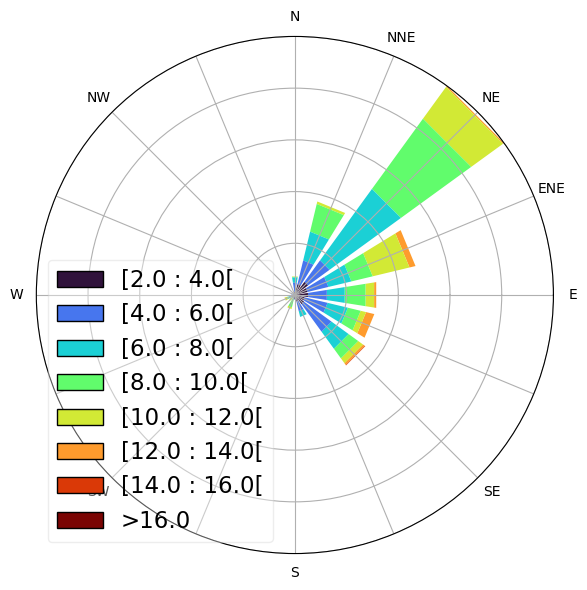

In [111]:
plt.style.use("default")
# plt.style.use('dark_background')
# ------------------------------------------------------------------------------

fig = plt.figure(figsize=(6, 6))

# sns.set_theme()
# sns.set_style("whitegrid")
# sns.color_palette("husl", 8)
# sns.color_palette("tab10")
# sns.set_context("talk")
# fig.suptitle(f"{period}", fontsize=25)
# plt.axis('off')

labels = [
    "E",
    "ENE",
    "NE",
    "NNE",
    "N",
    "NNW",
    "NW",
    "WNW",
    "W",
    "WSW",
    "SW",
    "SSW",
    "S",
    "SSE",
    "SE",
    "ESE",
]

ax1 = fig.add_subplot(111, projection="windrose")
ax1.set_thetagrids(
    angles=np.arange(0, 360, 22.5),
    labels=[
        "E",
        "ENE",
        "NE",
        "NNE",
        "N",
        "",
        "NW",
        "",
        "W",
        "",
        "SW",
        "",
        "S",
        "",
        "SE",
        "",
    ],
)

ax1.bar(
    met_df.met_WinddirectionRot_mean,
    met_df.met_WindSpeedRot_mean,
    normed=True,
    opening=0.8,
    edgecolor="None",
    bins=np.arange(2, 18, 2),
    cmap=cm.turbo,
)

# ax1.legend(title="Wind Speed")
ax1.legend(prop={"size": 16.5}, framealpha=0.35)
ax1.set_yticklabels([])


# ax2 = fig.add_subplot(121)
# font_size = 12
# bbox = [0.1, 0.2, 0.8, 0.6]
# ax2.axis("off")
# #
# mpl_table = ax2.table(cellText=met.values, bbox=bbox, colLabels=met.columns)
# mpl_table.auto_set_font_size(True)
# mpl_table.set_fontsize(font_size)


fig.tight_layout()
fig.savefig(f"./input/{period}/{period}-rose.svg", transparent=True)


plt.show()

## Speed bins

In [112]:
bj = np.arange(0, 25 + 1, 2)
bj

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24])

In [113]:
met_df.loc[:, "Vitesse"] = pd.cut(met_df.met_WindSpeedRot_mean, bj)

# met_df["Vitesse"] = met_df["Vitesse"].apply(lambda x: x.mid)
met_df

,met_WindSpeedRot_mean,met_WinddirectionRot_mean,Vitesse
TimeStamp,,,
2023-12-01 00:00:00,7.152525,202.663205,"(6, 8]"
2023-12-01 00:10:00,6.476140,199.991697,"(6, 8]"
2023-12-01 00:20:00,6.470416,199.500395,"(6, 8]"
2023-12-01 00:30:00,7.566415,196.251927,"(6, 8]"
2023-12-01 00:40:00,7.298517,200.894568,"(6, 8]"
...,...,...,...
2023-12-27 23:20:00,7.841715,58.954991,"(6, 8]"
2023-12-27 23:30:00,7.764787,59.467039,"(6, 8]"
2023-12-27 23:40:00,7.842830,58.841955,"(6, 8]"


In [114]:
(100 * met_df.groupby("Vitesse").count() / len(met_df)).round()

,met_WindSpeedRot_mean,met_WinddirectionRot_mean
Vitesse,,
"(0, 2]",1.0,1.0
"(2, 4]",12.0,12.0
"(4, 6]",21.0,21.0
"(6, 8]",26.0,26.0
"(8, 10]",23.0,23.0
"(10, 12]",13.0,13.0
"(12, 14]",2.0,2.0
"(14, 16]",0.0,0.0
"(16, 18]",0.0,0.0


# #4 Durée et frequence par categorie d'alarme

In [127]:
df_ax4 = (
    main_result_sum.groupby("Error Group")
    .agg(
        **{
            "Freq": ("Alarmcode", "count"),
            "Durée arrêts": ("RealPeriod", lambda x: x.sum().total_seconds() / 3600),
        }
    )
    .reindex(reorder)
    .dropna()
    .reset_index()
)

# df_ax4.plot(kind='bar', x='Error Group', ax=ax5)
df_ax4.to_clipboard(index=False, decimal=",")

df_ax4

,Error Group,Freq,Durée arrêts
0,System,840.0,2039.590000
1,Generator,3.0,1.672500
2,Hub,745.0,243.786389
3,Gear,8.0,53.482222
4,Grid,2.0,0.353333
5,Rotor,1.0,0.233611
6,Hydraulics,380.0,136.627778
7,Environement,9.0,5.035833
8,Brake,45.0,3.516111
9,Yaw,1382.0,474.771944


# #5 MTBF et MTTR par catégorie d'alarme

In [128]:
MTBF_MTTR_cat = (
    main_result_sum.query(mt_query, engine="python")
    .groupby("Error Group")
    .agg(Durée=("RealPeriod", lambda x: x.sum().total_seconds() / 3600), Freq=("TimeOn", "count"))
    .rename_axis("Catégorie")
    .sort_values("Freq", ascending=False)
    .reindex(reorder)
    .dropna()
    .reset_index()
)

duree_cumul = MTBF_MTTR_cat["Durée"]
freq_cumul = MTBF_MTTR_cat["Freq"]

MTBF_MTTR_cat["MTTR en h"] = duree_cumul / freq_cumul

MTBF_MTTR_cat["1 / (MTBF en j)"] = 1e3 / (
    ((days_in_cumul * 24 * 131) - duree_cumul) / (freq_cumul * 24)
)

MTBF_MTTR_cat = MTBF_MTTR_cat.round(2)

MTBF_MTTR_cat

,Catégorie,Durée,Freq,MTTR en h,1 / (MTBF en j)
0,System,60.86,7.0,8.69,0.15
1,Hub,177.08,15.0,11.81,0.32
2,Gear,51.63,4.0,12.91,0.08
3,Hydraulics,129.99,14.0,9.28,0.30
4,Environement,2.90,1.0,2.90,0.02
5,Yaw,164.19,29.0,5.66,0.61
6,Converter-1,787.74,11.0,71.61,0.23
7,Controller,42.02,7.0,6.00,0.15
8,MISCELLANEOUS,281.54,3.0,93.85,0.06


In [129]:
df_ax5 = MTBF_MTTR_cat[["Catégorie", "MTTR en h", "1 / (MTBF en j)"]]
# df_ax5.rename(columns={'MTTR en h': 'MTTR', 'MTBF en j': 'MTBF'}, inplace=True)

df_ax5.to_clipboard(index=False, decimal=",")
df_ax5

,Catégorie,MTTR en h,1 / (MTBF en j)
0,System,8.69,0.15
1,Hub,11.81,0.32
2,Gear,12.91,0.08
3,Hydraulics,9.28,0.30
4,Environement,2.90,0.02
5,Yaw,5.66,0.61
6,Converter-1,71.61,0.23
7,Controller,6.00,0.15
8,MISCELLANEOUS,93.85,0.06


# #6 Durée et fréquence par code d'alarme

In [130]:
df_ax6 = (
    main_result_sum.groupby(["UK Text", "Alarmcode"])
    .agg(
        **{
            "Freq": ("Alarmcode", "count"),
            "Arrêts TAREC": ("RealPeriod", lambda x: x.sum().total_seconds() / 3600),
            "Type": ("Error Type", "first"),
        }
    )
    .sort_values("Arrêts TAREC", ascending=False)
    .head(20)
    .reset_index()
)

df_ax6.loc[df_ax6.Type == 1, "Arrêts SGRE"] = df_ax6.loc[df_ax6.Type == 1, "Arrêts TAREC"]
df_ax6.loc[df_ax6.Type == 1, "Arrêts TAREC"] = np.nan
df_ax6.drop(columns="Type", inplace=True)

# df_ax6.plot(kind='bar', x='Alarmcode', ax=ax6)
df_ax6.to_clipboard(index=False, decimal=",")
df_ax6

,UK Text,Alarmcode,Freq,Arrêts TAREC,Arrêts SGRE
0,Manual stop,1001,494,NaN,1505.763889
1,"Converter trip, external",13911,2,NaN,721.831944
2,Manual idle stop - yawing,1025,188,NaN,357.323889
3,Main breaker tripped,64066,3,NaN,281.536111
4,Yaw fail waiting,10400,803,NaN,155.435833
5,Yaw fail stopped,10401,96,NaN,140.881944
6,Hyd oil level error,7101,344,NaN,105.911389
7,"Stopped, untwisting cables",10105,442,104.793056,NaN
8,Availability - low wind,1005,122,100.892778,NaN
9,Yaw motor(s) superheated,10100,37,NaN,53.440833


# #7 Durée et fréquence des arrets par turbine

In [133]:
df_ax7 = (
    pd.merge(
        (
            results.query("wtc_ActPower_min <= 0")
            .groupby("StationId")
            .agg(
                **{
                    "Durée arrêts": ("RealPeriod", lambda x: x.sum() / 3600),
                }
            )
            .reset_index()
        ),
        (
            period_alarms.groupby("StationId")
            .agg(
                **{
                    "Freq arrêts": (
                        "Alarmcode",
                        lambda x: int(x[x == 115].count() / 2),
                    ),
                }
            )
            .reset_index()
        ),
    )
    .sort_values("Durée arrêts", ascending=False)
    .head(20)
)

# df_ax7.plot(kind='bar', x='StationId', ax=ax8)
# for stacked bar excel chart


df_ax7.to_clipboard(index=False, decimal=",")
df_ax7

,StationId,Durée arrêts,Freq arrêts
62,63,744.000000,0
39,40,327.135833,10
66,67,181.485833,10
5,6,144.868333,38
32,33,98.371944,36
1,2,97.700833,36
45,46,96.968611,42
109,110,96.579167,26
46,47,95.057500,30
28,29,76.097500,23


# #8 Pièces de rechange

In [134]:
import unicodedata


def remove_accents(input_str):
    nfkd_form = unicodedata.normalize("NFKD", input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])


period_month_name_ascii = remove_accents(period_month_name).upper()


### Convert canvas after manual tidying (unmerge cells & unsplit)

In [136]:
parts = pd.read_excel(
    f"./input/{period}/PART REPLACED SGRE SERVICE {period}.xlsx",
    header=7,
    sheet_name=period_month_name_ascii,
)

parts.dropna(subset=["DESCRIPTION"], inplace=True)

parts.reset_index(drop=True, inplace=True)

parts = parts[["DESCRIPTION", "QTE"]]

parts.rename(columns={"DESCRIPTION": "REFERENCE", "QTE": "QTE SORTIE"}, inplace=True)

parts["REFERENCE"] = parts["REFERENCE"].str.upper().str.strip()

parts = parts.astype({"QTE SORTIE": int})

parts

,REFERENCE,QTE SORTIE
0,A9B00017521,2
1,A9B00018030,1
2,A9B00026251,1
3,A9B00081176,2
4,A9B00082519,2
...,...,...
134,A9B10207591,1
135,A9B10243060,1
136,A9B00017563,3
137,A9B00021051,1


In [137]:
parts.query("`QTE SORTIE`.isna()")

,REFERENCE,QTE SORTIE


In [138]:
(
    len(max(parts["REFERENCE"], key=len)),
    len(min(parts["REFERENCE"], key=len)),
)

(11, 11)

In [139]:
(
    (max(parts["REFERENCE"], key=len)),
    (min(parts["REFERENCE"], key=len)),
)

('A9B00017521', 'A9B00017521')

In [140]:
parts.isna().sum()

REFERENCE     0
QTE SORTIE    0
dtype: int64

In [143]:
df_ax11_last = pd.read_excel(
    f"./results/{previous_period}/TB Performance {previous_period}.xlsx",
    sheet_name="ax11",
    skiprows=1,
    usecols="C:E",
)


df_ax11 = parts.rename(columns={"REFERENCE": "item", "QTE SORTIE": period_month_name})

df_ax11 = df_ax11.groupby("item").sum().reset_index()[["item", period_month_name]]

# if period_month == 1: # desactive car cumul depuis 2020

#     df_ax11['Year'] = df_ax11[period_month_name].fillna(0)
#     df_ax11 = df_ax11[['item', 'Year', period_month_name]]

# else:
df_ax11 = df_ax11_last.merge(df_ax11, how="outer")[["item", "Year", period_month_name]]
df_ax11["Year"] = df_ax11["Year"].fillna(0) + df_ax11[period_month_name].fillna(0)

df_ax11 = df_ax11.fillna(0).astype(int, errors="ignore")

df_ax11.to_clipboard(index=False, decimal=",")
df_ax11

,item,Year,Décembre
0,A9B10055151,662,0
1,A9B00573133,196,0
2,A9B10027591,48,0
3,A9B00075055,339,0
4,A9B00019620,332,0
...,...,...,...
658,A9B10023186,6,6
659,A9B10023187,6,6
660,A9B10043594,1,1
661,A9B10097105,24,24


In [142]:
df_ax11.loc[df_ax11.item.duplicated()]

,item,Year,Décembre


# #9 Energie perdue en MWh

In [145]:
df_ax9 = (
    results[["StationId", "ELNX", "ELX", "EL_indefini_left", "EL_Misassigned"]]
    .groupby("StationId")
    .sum()
    .sort_values("StationId")
    # .head(20)
    .reset_index()
)

df_ax9["ELNX"] = df_ax9["ELNX"] + df_ax9["EL_Misassigned"]
df_ax9["ELX"] = df_ax9["ELX"] - df_ax9["EL_Misassigned"]

df_ax9[["ELNX", "ELX", "EL_indefini_left", "EL_Misassigned"]] = (
    df_ax9[["ELNX", "ELX", "EL_indefini_left", "EL_Misassigned"]] / 1e3
)

df_ax9.rename({"ELNX": "Energie perdue SGRE", "ELX": "Energie perdue TAREC"}, inplace=True, axis=1)

df_ax9 = df_ax9.round(2)

df_ax9.to_clipboard(index=False, decimal=",")
df_ax9

,StationId,Energie perdue SGRE,Energie perdue TAREC,EL_indefini_left,EL_Misassigned
0,1,21.420000,1.35,0.00,0.00
1,2,54.490002,1.82,0.00,2.38
2,3,55.150002,3.28,0.00,1.79
3,4,27.780001,1.53,0.08,2.02
4,5,55.110001,2.92,0.00,2.06
...,...,...,...,...,...
126,127,3.530000,0.84,0.28,0.14
127,128,0.000000,0.70,0.00,0.00
128,129,55.849998,0.76,0.00,0.00
129,130,0.000000,0.79,0.00,0.00


In [7]:
results.query("StationId == 112").to_clipboard(index=False, decimal=",")

In [17]:
df = pd.DataFrame({"A": [1, 2, 3], "B": [4, np.nan, 6], "C": [7, 8, 9]})

df

,A,B,C
0,1,4.0,7
1,2,NaN,8
2,3,6.0,9


In [18]:
df.query("A == 2 & B > 1")

,A,B,C


# #13 Énergie consommée

In [146]:
onee_tah = pd.read_excel(f"./input/{period}/CCH TAREC TAH {period}.xlsx")
onee_nord = pd.read_excel(f"./input/{period}/CCH TAREC NORD {period}.xlsx")

onee = pd.concat([onee_tah, onee_nord])
onee.head(2)

,Unnamed: 0,Account:,Date,Time,Int.Len,kWh-Del,kVARh-Del,kWh-Rec,kVARh-Rec
0,TR,NORM,2023-12-01,00:10:00,10,0,0,93060,3432
1,TR,NORM,2023-12-01,00:20:00,10,0,0,96756,4224


## Par mois

In [147]:
(onee.groupby(onee.Date.dt.to_period("M")).sum(numeric_only=True) / 6 / 1e3)

,Int.Len,kWh-Del,kVARh-Del,kWh-Rec,kVARh-Rec
Date,,,,,
2023-12,14.88,164.604,21383.67,58702.27,717.728


In [106]:
onee.sum(numeric_only=True) / 6 / 1e3

Int.Len         14.400
kWh-Del         49.973
kVARh-Del    14885.156
kWh-Rec      67766.512
kVARh-Rec      682.583
dtype: float64

## Par turbine

In [26]:
cumul_results.groupby(cumul_results.TimeStamp.dt.to_period("M")).sum(numeric_only=True)[["wtc_kWG1TotI_accum"]].reset_index().sum()

C:\Users\saada\AppData\Local\Temp\ipykernel_39508\3724461552.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cumul_results.groupby(cumul_results.TimeStamp.dt.to_period("M")).sum(numeric_only=True)[["wtc_kWG1TotI_accum"]].reset_index().sum()


wtc_kWG1TotI_accum    714539.0
dtype: float64

In [148]:
results.groupby("StationId").sum(numeric_only=True)[["wtc_kWG1TotI_accum"]].reset_index()

,StationId,wtc_kWG1TotI_accum
0,1,1493.0
1,2,1540.0
2,3,1378.0
3,4,1399.0
4,5,1386.0
...,...,...
126,127,1949.0
127,128,1728.0
128,129,1708.0
129,130,1748.0


In [149]:
from sys import maxsize

# from turtle import title
import plotly.express as px

fig = px.scatter_mapbox(
    (results.groupby("StationId").sum(numeric_only=True)[["wtc_kWG1TotI_accum"]] / 1e3)
    .reset_index()
    .merge(df_coords, on="StationId", how="left"),
    lat="lat",
    lon="lon",
    hover_name="StationId",
    # hover_data=["wtc_AcWindSp_mean"],
    color="wtc_kWG1TotI_accum",
    color_continuous_scale="Turbo",
    # size_max=100,
    zoom=11.7,
    height=850,
    width=1000,
    title="x",
    center={"lat": 27.7787632, "lon": -12.9051846},
    labels={"wtc_kWG1TotI_accum": "Conso MWh"},
)

title = "Énergie consommée par turbine"
fig.update_layout(
    mapbox_style="open-street-map",
    title={"text": title, "x": 0.5, "xref": "paper", "font": dict(size=20)},
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
)
fig.update_layout(margin={"r": 0, "t": 30, "l": 0, "b": 0})

fig.update_traces(
    marker=dict(
        size=14,
    )
)


fig.update_geos(projection_type="orthographic")

fig.show()
# fig.write_html("Vitesse moyenne Turbines Janvier à Décembre 2022.html")
fig.write_image(f"./input/{period}/{title}.svg")

# #14 Boost

In [33]:
def read_boost(period):
    usecols_cnt = """TimeStamp, StationId, wtc_BoostKWh_endvalue, wtc_BostkWhS_endvalue"""

    sql_cnt = f"Select {usecols_cnt} FROM tblSCTurCount;"

    cnt = zip2mdb2df(data_type="CNT", sql=sql_cnt, period=period)

    cnt["TimeStamp"] = pd.to_datetime(cnt["TimeStamp"], format="%m/%d/%y %H:%M:%S")

    return cnt


def boost_endvalue_check(df):
    df = df.reset_index().sort_values("TimeStamp")
    df.drop("index", axis=1, inplace=True)
    clmn = df["wtc_BoostKWh_endvalue"]
    x = (clmn.iat[-1] - clmn.iat[0]) / 1000
    # df = df.diff().query('wtc_BoostKWh_endvalue < 0')
    return max(x, 0)

In [34]:
# last_boost_cumul = input('last_boost_cumul') or 3458.1

boost = read_boost(period)
boost["StationId"] = boost["StationId"] - 2307404

boost_period = boost.groupby("StationId").apply(lambda df: boost_endvalue_check(df)).sum()


if period_month == 1:
    boost_cumul = boost_period
else:
    boost_cumul = last_boost_cumul + boost_period

2024-02-01 15:22:23,651 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId, wtc_BoostKWh_endvalue, wtc_BostkWhS_endvalue FROM tblSCTurCount;
2024-02-01 15:22:23,652 INFO sqlalchemy.engine.Engine [raw sql] ()


In [35]:
boost.groupby(["StationId", boost.TimeStamp.dt.to_period("d")]).apply(lambda df: boost_endvalue_check(df)).groupby("TimeStamp").sum()

TimeStamp
2024-01-01     0.000000
2024-01-02     0.000000
2024-01-03     0.000000
2024-01-04     0.000000
2024-01-05     0.000000
2024-01-06     0.000000
2024-01-07     0.000000
2024-01-08     0.000000
2024-01-09     0.000000
2024-01-10     0.009781
2024-01-11     0.000000
2024-01-12    14.440516
2024-01-13    33.619344
2024-01-14    15.540672
2024-01-15     2.695328
2024-01-16     6.434922
2024-01-17     0.000000
2024-01-18     0.000000
2024-01-19     0.132406
2024-01-20    65.073531
2024-01-21    77.457688
2024-01-22    10.699516
2024-01-23    36.136313
2024-01-24    60.513359
2024-01-25    48.576406
2024-01-26    21.211688
2024-01-27     5.435953
2024-01-28     0.000000
2024-01-29     0.000000
2024-01-30    12.677453
2024-01-31    74.142437
2024-02-01     0.000000
Freq: D, dtype: float64

In [36]:
boost_period, boost_cumul

(488.74339062499996, 488.74339062499996)

## Per turbine/month

In [16]:
boost_cumul = pd.DataFrame()

for month in range(1, period_month + 1):  # range(1, period_month+1):

    period_cumul = f"{str(period_year).zfill(2)}-{str(month).zfill(2)}"

    # -------------------------------------------------------------------------
    boost_cumul = pd.concat([boost_cumul, read_boost(period_cumul)])

boost_cumul["StationId"] = boost_cumul["StationId"] - 2307404


2024-01-15 12:14:29,627 INFO sqlalchemy.engine.Engine Select TimeStamp, StationId, wtc_BoostKWh_endvalue, wtc_BostkWhS_endvalue FROM tblSCTurCount;
2024-01-15 12:14:29,628 INFO sqlalchemy.engine.Engine [raw sql] ()


In [17]:
boost_cumul

,TimeStamp,StationId,wtc_BoostKWh_endvalue,wtc_BostkWhS_endvalue
0,2024-01-01,1,716644.12500,4124.799805
1,2024-01-01,2,726290.50000,3151.699951
2,2024-01-01,3,460551.00000,3049.399902
3,2024-01-01,4,750001.00000,3424.699951
4,2024-01-01,5,753452.31250,2371.300049
...,...,...,...,...
255933,2024-01-15,127,477133.18750,435.600006
255934,2024-01-15,128,461113.81250,372.799988
255935,2024-01-15,129,234778.59375,426.399994
255936,2024-01-15,130,448276.90625,248.500000


In [18]:
boost

,TimeStamp,StationId,wtc_BoostKWh_endvalue,wtc_BostkWhS_endvalue
0,2023-12-01,1,712519.312500,10188.000000
1,2023-12-01,2,723138.812500,9696.400391
2,2023-12-01,3,457501.593750,9932.200195
3,2023-12-01,4,746576.312500,9845.900391
4,2023-12-01,5,751081.000000,9777.299805
...,...,...,...,...
502686,2023-12-28,127,476697.593750,1356.199951
502687,2023-12-28,128,460740.906250,1370.099976
502688,2023-12-28,129,234352.203125,517.599976
502689,2023-12-28,130,447992.312500,1736.300049


### Turbine

In [152]:
boost_turbine = boost.groupby("StationId").apply(lambda df: boost_endvalue_check(df))

boost_turbine = boost_turbine.to_frame().merge(df_coords, on="StationId", how="left")
boost_turbine.rename(columns={0: "Boost MWh"}, inplace=True)
boost_turbine

,StationId,Boost MWh,lat,lon
0,1,4.124812,27.851773,-12.890785
1,2,3.151687,27.850717,-12.887961
2,3,3.049406,27.849768,-12.885450
3,4,3.424688,27.848848,-12.882779
4,5,2.371313,27.847700,-12.880139
...,...,...,...,...
125,127,1.356188,27.724365,-12.926529
126,128,1.370094,27.725363,-12.929147
127,129,0.517609,27.726360,-12.931722
128,130,1.736312,27.727366,-12.934350


In [116]:
boost_turbine["Boost MWh"].max()

2.1461875

In [153]:
from sys import maxsize

# from turtle import title
import plotly.express as px

fig = px.scatter_mapbox(
    boost_turbine,
    lat="lat",
    lon="lon",
    hover_name="StationId",
    # hover_data=["wtc_AcWindSp_mean"],
    color="Boost MWh",
    color_continuous_scale="Turbo",
    # size_max=100,
    zoom=11.7,
    height=850,
    width=1000,
    title="x",
    center={"lat": 27.7787632, "lon": -12.9051846},
    range_color=[0, boost_turbine["Boost MWh"].max()]
)

title = "Boost par Turbine"
fig.update_layout(
    mapbox_style="open-street-map",
    title={"text": title, "x": 0.5, "xref": "paper", "font": dict(size=20)},
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
)
fig.update_layout(margin={"r": 0, "t": 30, "l": 0, "b": 0})

fig.update_traces(
    marker=dict(
        size=14,
    )
)


fig.update_geos(projection_type="orthographic")

fig.show()
# fig.write_html("Vitesse moyenne Turbines Janvier à Décembre 2022.html")
fig.write_image(f"./input/{period}/{title}.svg")

### Month

In [19]:
boost_month = (
    boost_cumul.groupby(boost_cumul.TimeStamp.dt.to_period("M"))
    .apply(
        lambda boost_cumul: boost_cumul.groupby("StationId").apply(lambda df: boost_endvalue_check(df)).sum()
    )
    .to_frame()
)
boost_month

,0
TimeStamp,
2024-01,63.610313
